Initial graph setup:
Graph has 20 nodes and 30 edges


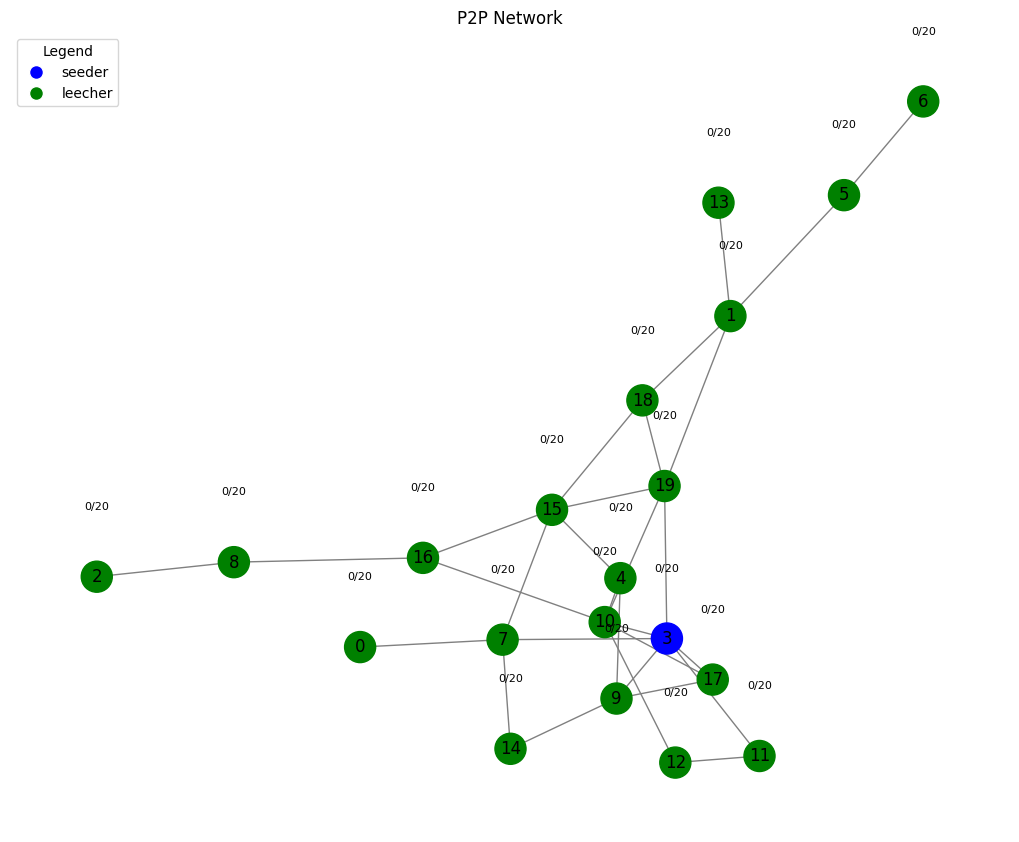

In [3]:
import sys, os, pathlib
project_root = pathlib.Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.graph import erdos_renyi_graph
import src.agent as agent_module
from utils.plotter import draw_graph, draw_graph_with_transfers
from utils.simulator import simulate_round, get_network_stats

# Create and setup the graph
G = erdos_renyi_graph(n=20, p=0.1)
agent_module.assign_n_seeders(G, n=1, seed=42)
FILE_PIECES = 20
print("Initial graph setup:")
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
draw_graph(G, FILE_PIECES)


In [4]:
# Init
agent_module.initialize_file_sharing(G, FILE_PIECES, seed=42)

print(str(FILE_PIECES) + " pieces")
for node in G.nodes():
    info = agent_module.get_agent_info(G, node)
    print(f"Node {node}: {info['role']} - {info['num_pieces']}/ {FILE_PIECES} pieces - Complete: {info['is_complete']}")

print(f"\nTotal pieces in network at the moment: {sum(len(G.nodes[node].get('file_pieces', set())) for node in G.nodes())}")


20 pieces
Node 0: leecher - 0/ 20 pieces - Complete: False
Node 1: leecher - 0/ 20 pieces - Complete: False
Node 2: leecher - 0/ 20 pieces - Complete: False
Node 3: seeder - 20/ 20 pieces - Complete: True
Node 4: leecher - 0/ 20 pieces - Complete: False
Node 5: leecher - 0/ 20 pieces - Complete: False
Node 6: leecher - 0/ 20 pieces - Complete: False
Node 7: leecher - 0/ 20 pieces - Complete: False
Node 8: leecher - 0/ 20 pieces - Complete: False
Node 9: leecher - 0/ 20 pieces - Complete: False
Node 10: leecher - 0/ 20 pieces - Complete: False
Node 11: leecher - 0/ 20 pieces - Complete: False
Node 12: leecher - 0/ 20 pieces - Complete: False
Node 13: leecher - 0/ 20 pieces - Complete: False
Node 14: leecher - 0/ 20 pieces - Complete: False
Node 15: leecher - 0/ 20 pieces - Complete: False
Node 16: leecher - 0/ 20 pieces - Complete: False
Node 17: leecher - 0/ 20 pieces - Complete: False
Node 18: leecher - 0/ 20 pieces - Complete: False
Node 19: leecher - 0/ 20 pieces - Complete: False



Initial: 19 leechers incomplete, 0.0% completion rate

 Round 1
Transfers: 1
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 16: 3 to >> 9


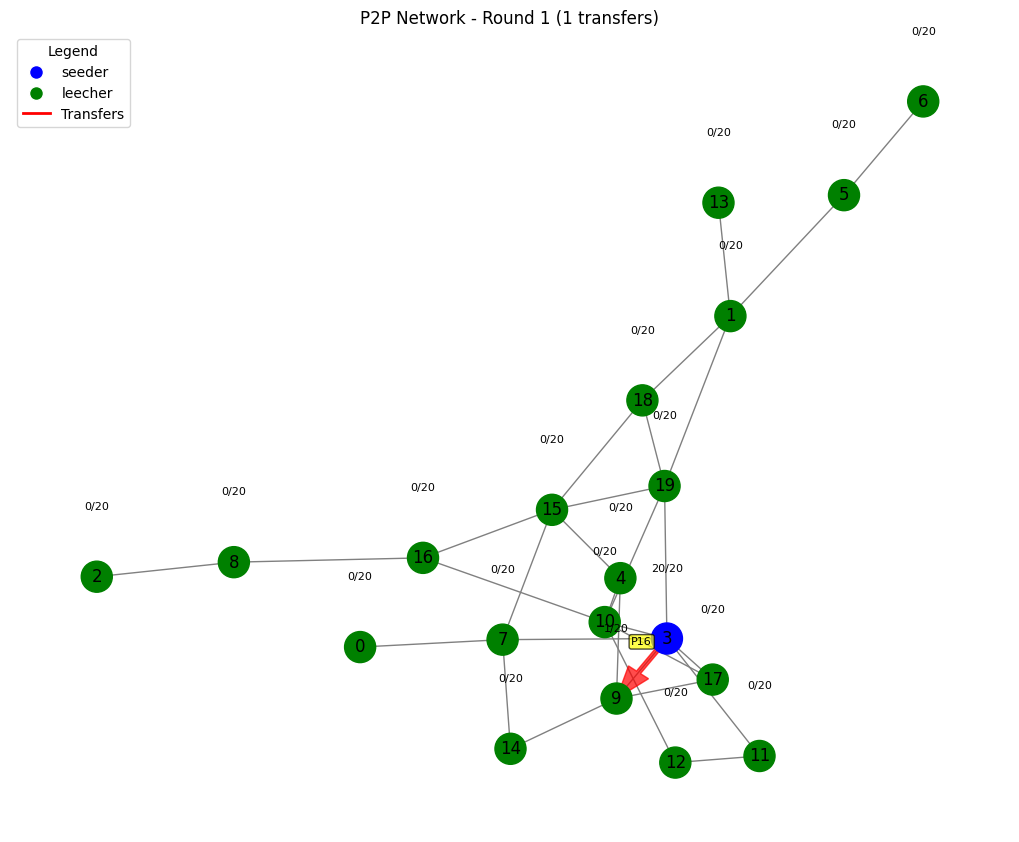


 Round 2
Transfers: 2
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 15: 3 to >> 11
  Piece 16: 9 to >> 4


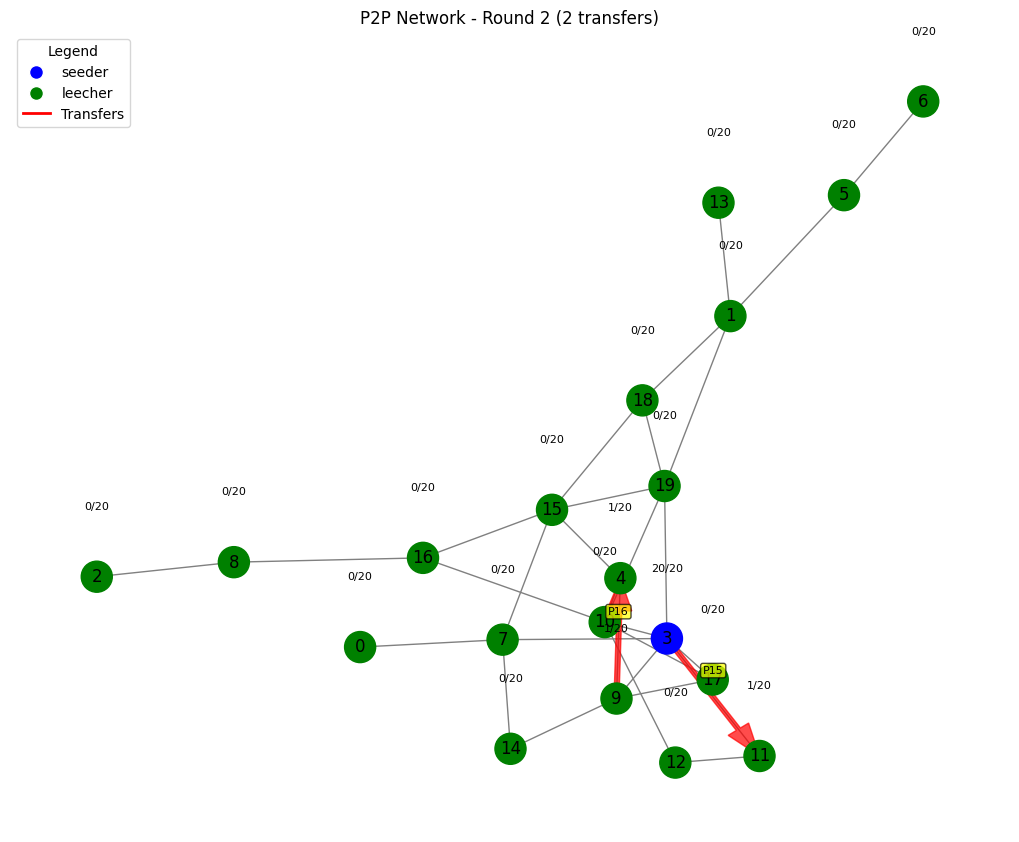


 Round 3
Transfers: 4
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 6: 3 to >> 17
  Piece 16: 4 to >> 15
  Piece 16: 9 to >> 14
  Piece 15: 11 to >> 12


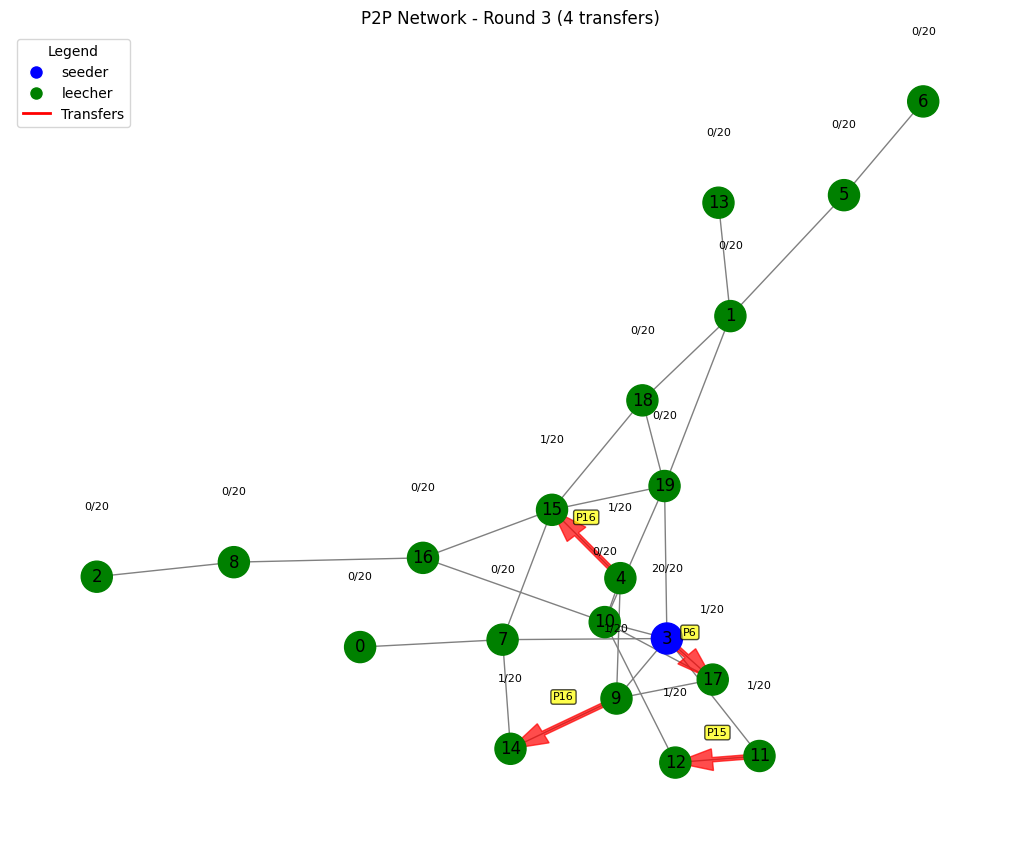


 Round 4
Transfers: 2
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 3: 3 to >> 17
  Piece 16: 15 to >> 16


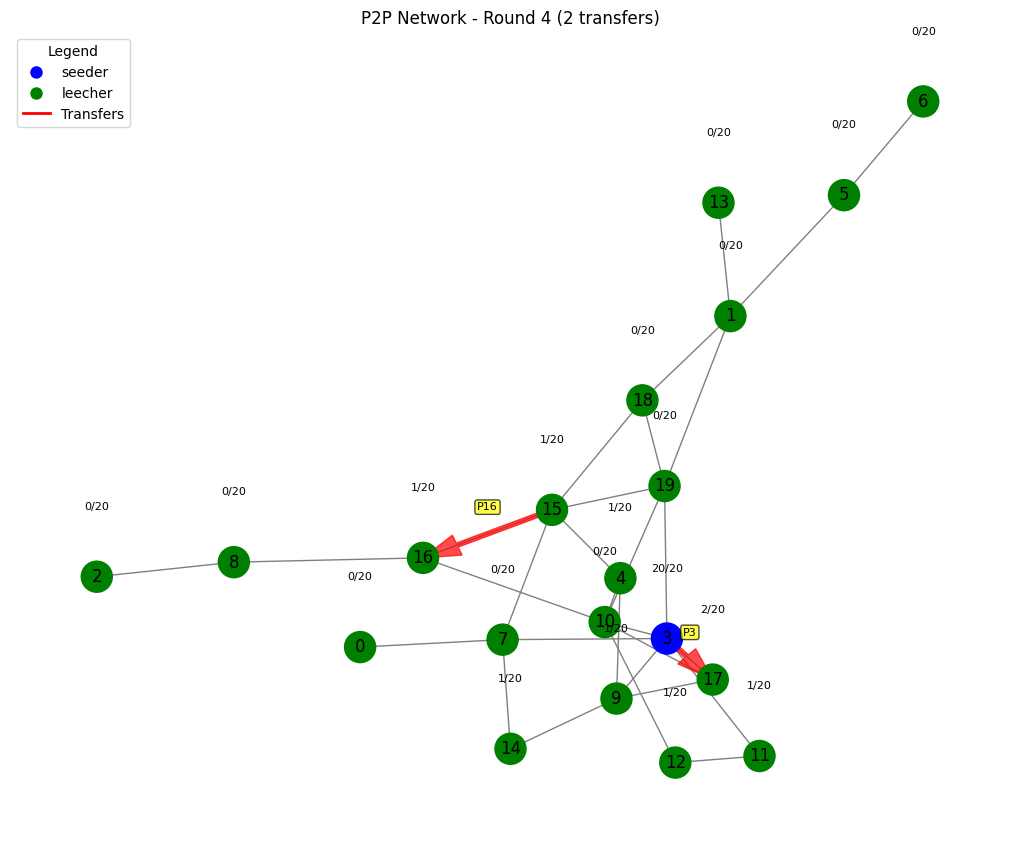


 Round 5
Transfers: 3
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 17: 3 to >> 9
  Piece 16: 15 to >> 18
  Piece 16: 16 to >> 8


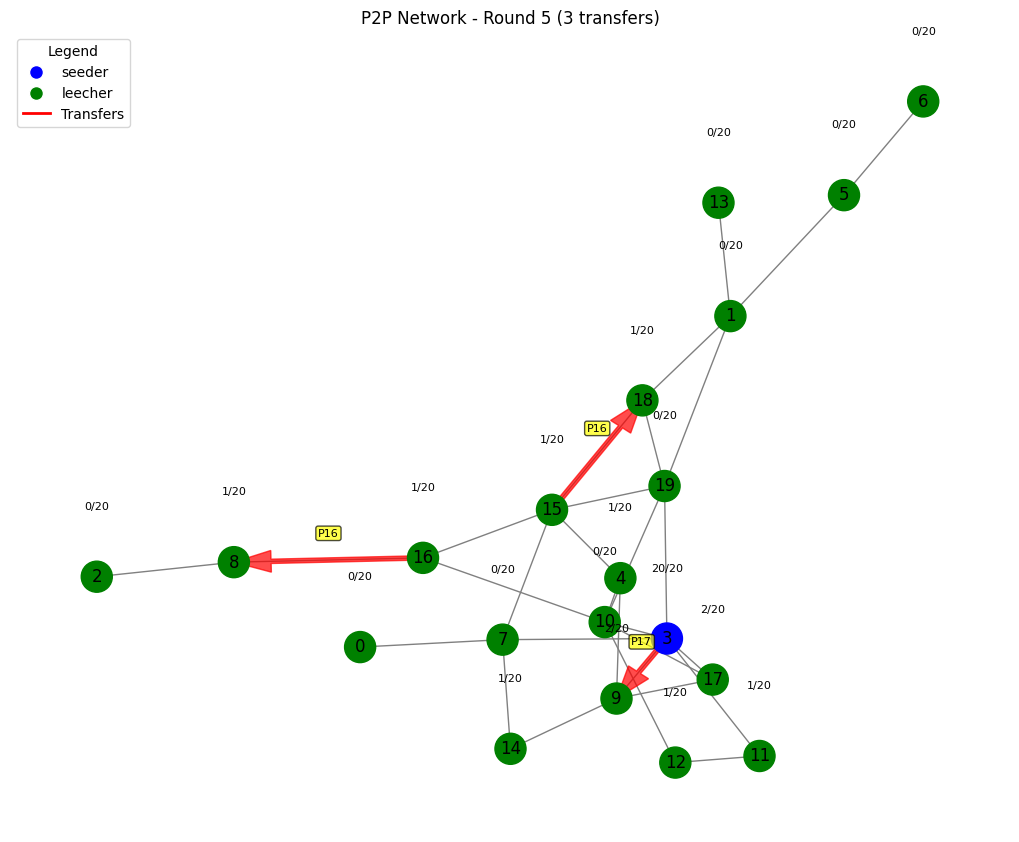


 Round 6
Transfers: 4
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 2: 3 to >> 10
  Piece 16: 8 to >> 2
  Piece 17: 9 to >> 14
  Piece 16: 18 to >> 1


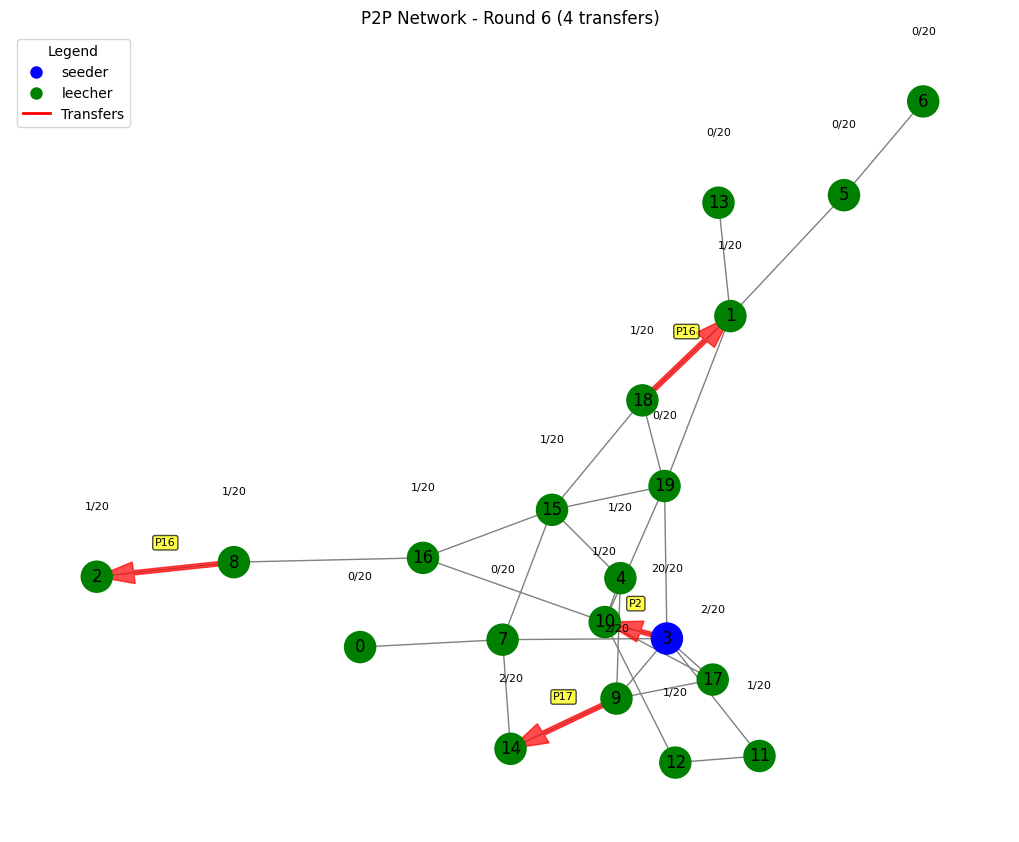


 Round 7
Transfers: 4
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 16: 1 to >> 19
  Piece 13: 3 to >> 10
  Piece 17: 9 to >> 4
  Piece 2: 10 to >> 12


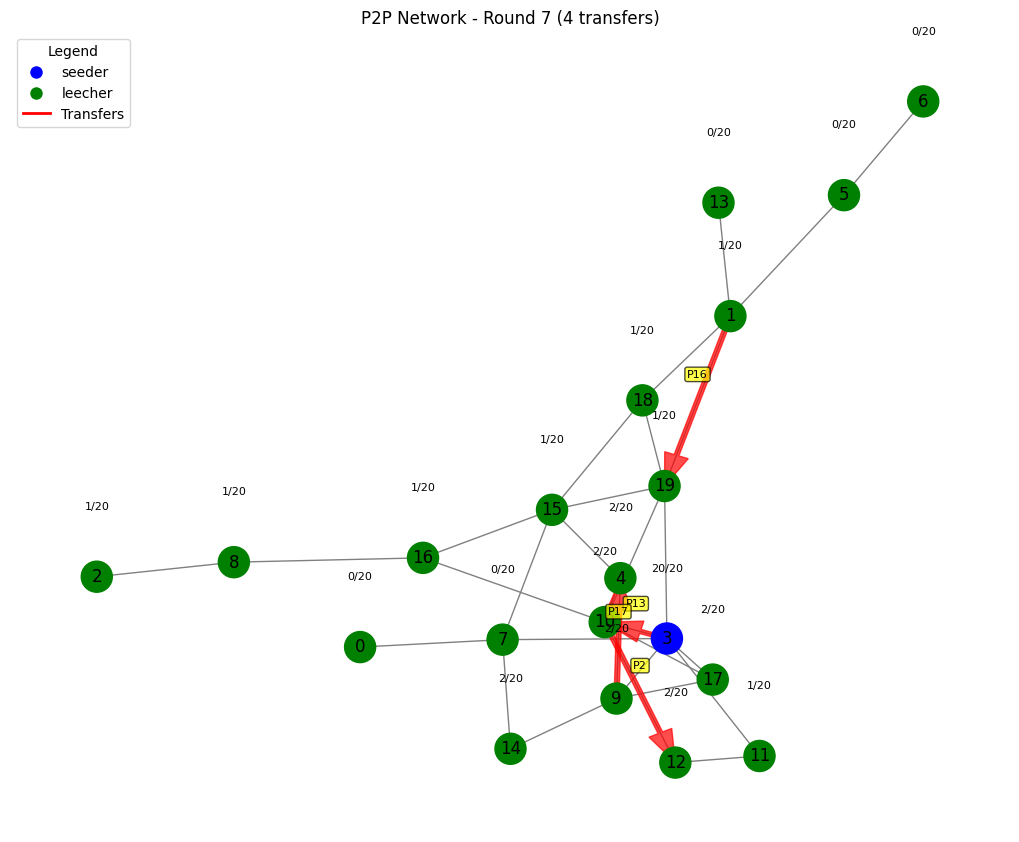


 Round 8
Transfers: 4
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 16: 1 to >> 5
  Piece 13: 3 to >> 9
  Piece 17: 4 to >> 15
  Piece 2: 10 to >> 16


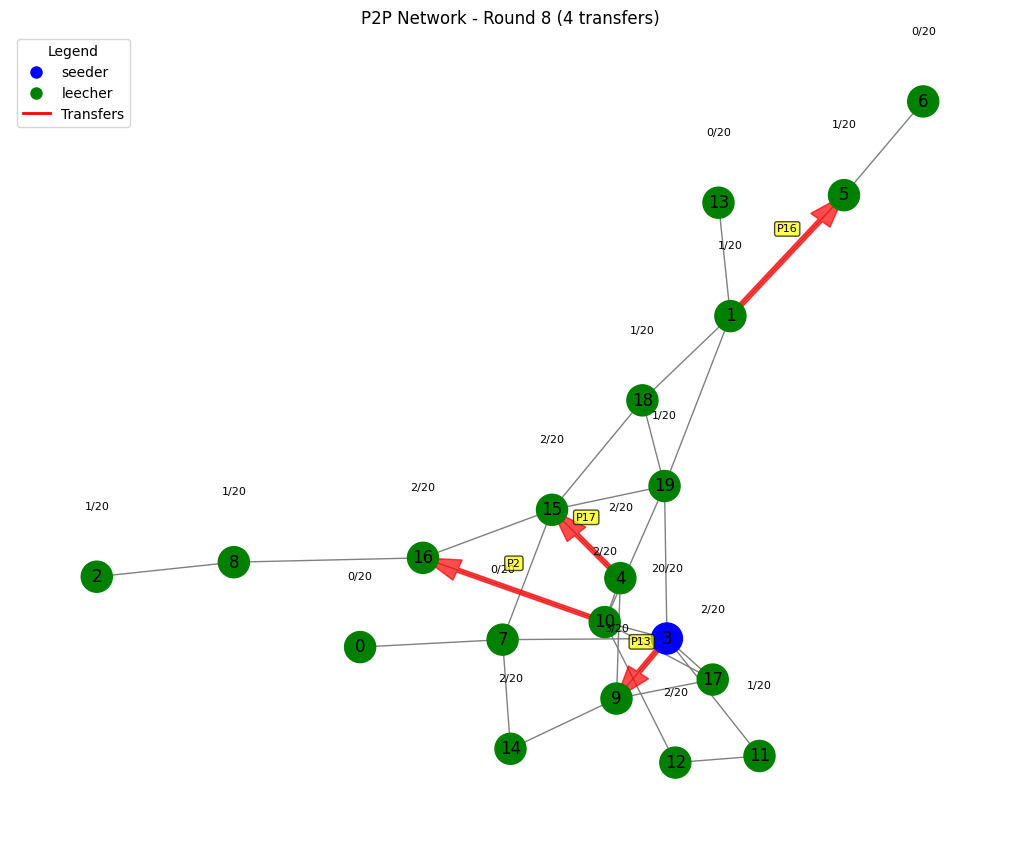


 Round 9
Transfers: 7
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 16: 1 to >> 13
  Piece 10: 3 to >> 11
  Piece 16: 5 to >> 6
  Piece 13: 9 to >> 14
  Piece 13: 10 to >> 12
  Piece 17: 15 to >> 18
  Piece 2: 16 to >> 8


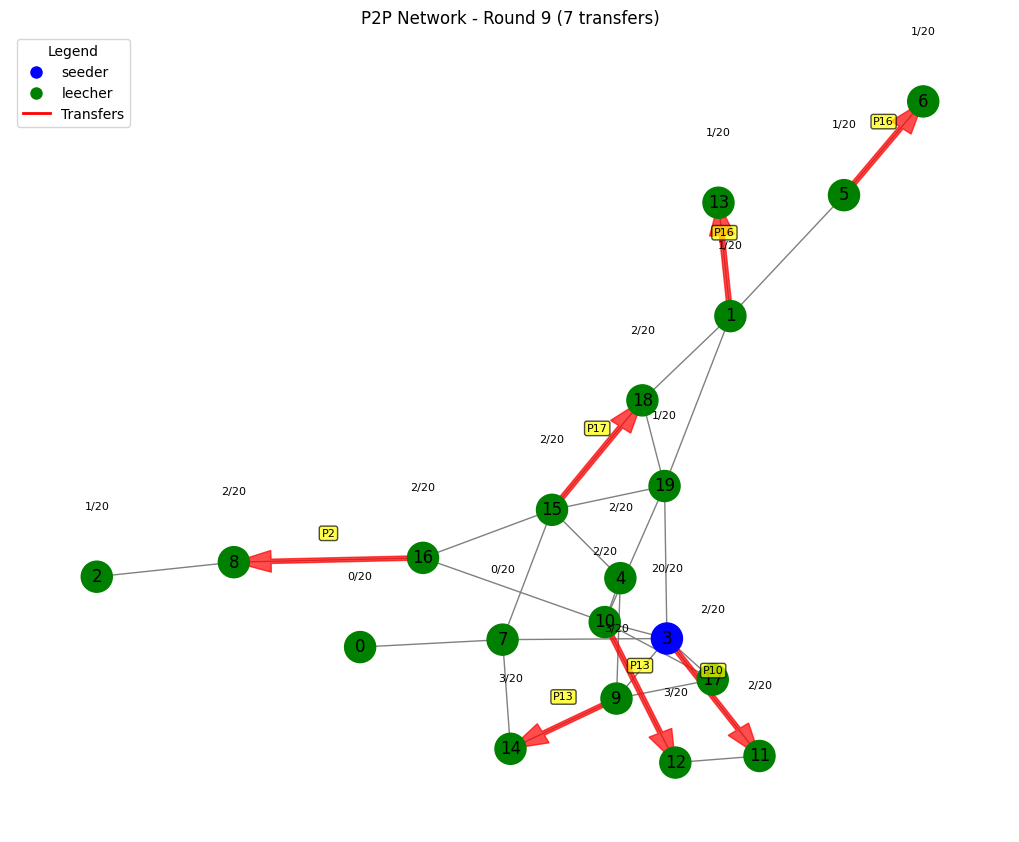


 Round 10
Transfers: 7
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 7: 3 to >> 10
  Piece 2: 8 to >> 2
  Piece 13: 9 to >> 4
  Piece 13: 10 to >> 16
  Piece 10: 11 to >> 12
  Piece 2: 16 to >> 15
  Piece 17: 18 to >> 1


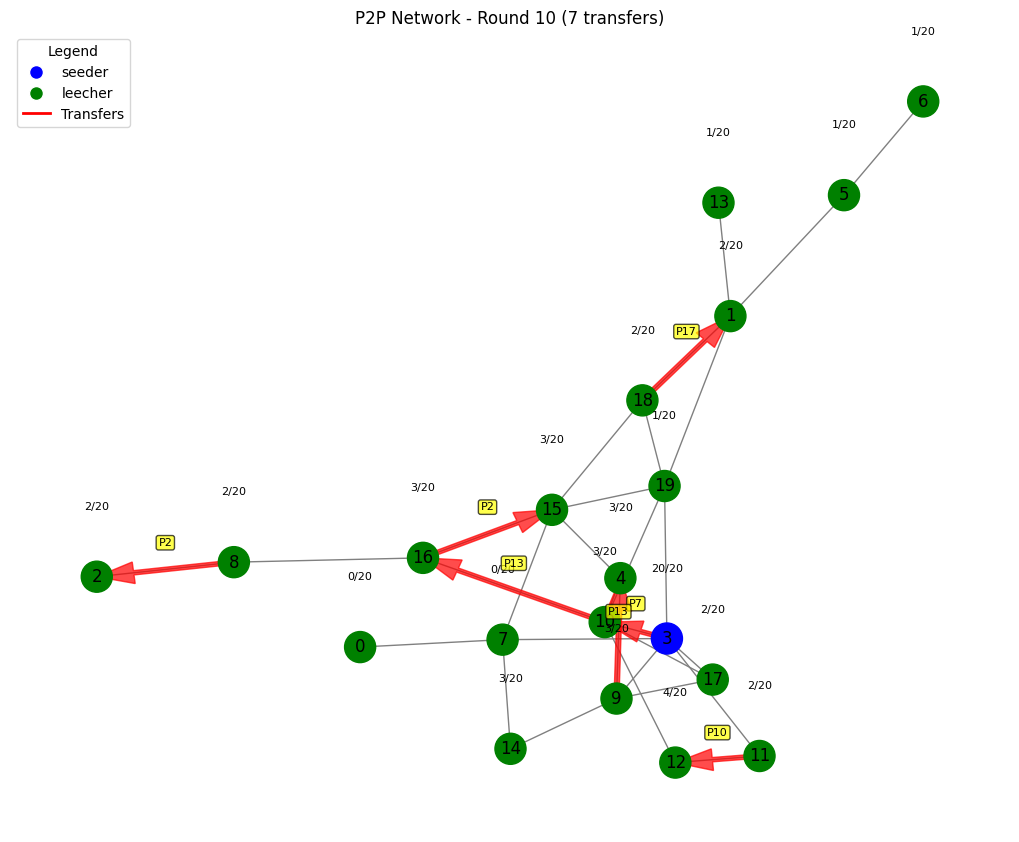


 Round 11
Transfers: 6
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 17: 1 to >> 13
  Piece 17: 3 to >> 7
  Piece 13: 4 to >> 15
  Piece 2: 10 to >> 4
  Piece 2: 15 to >> 18
  Piece 13: 16 to >> 8


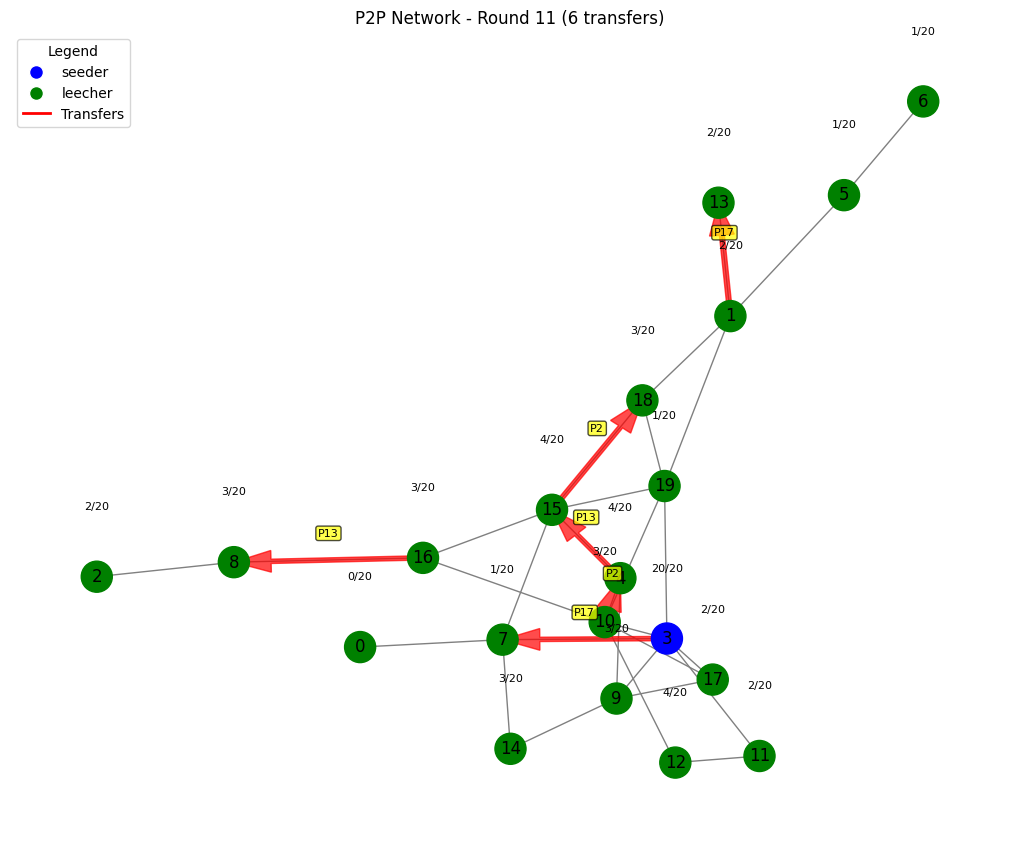


 Round 12
Transfers: 7
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 17: 1 to >> 5
  Piece 16: 3 to >> 7
  Piece 17: 7 to >> 0
  Piece 13: 8 to >> 2
  Piece 7: 10 to >> 12
  Piece 13: 15 to >> 18
  Piece 2: 18 to >> 1


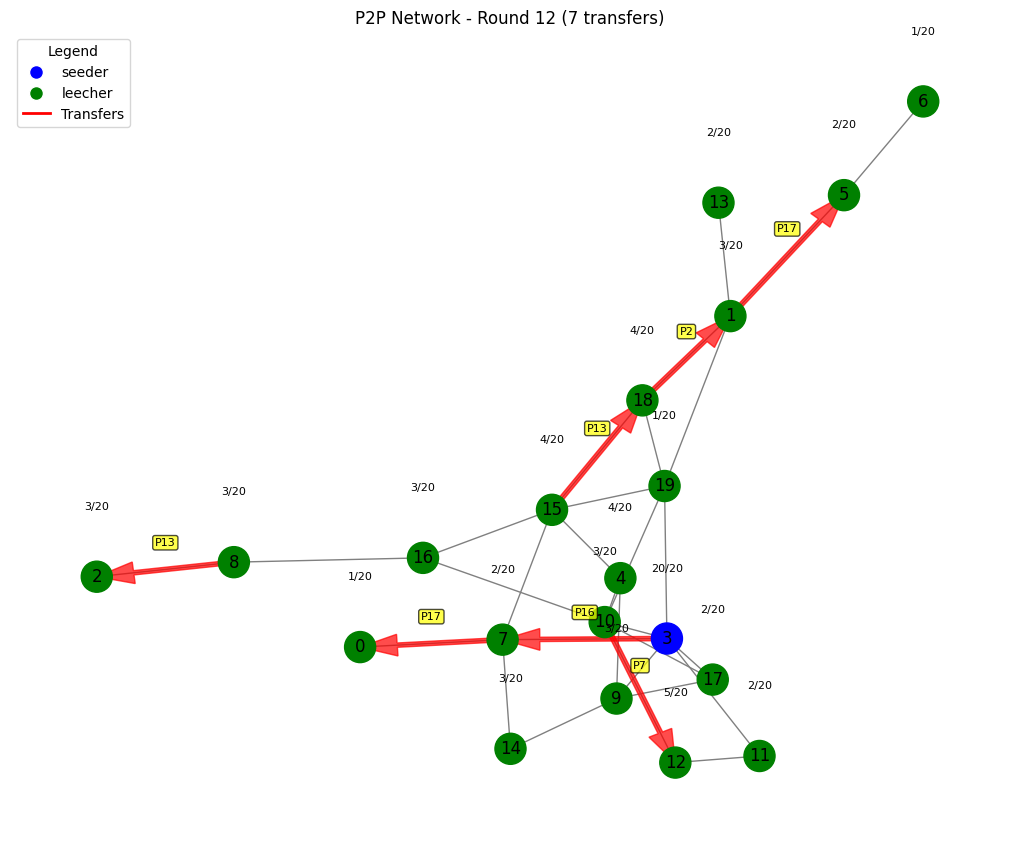


 Round 13
Transfers: 6
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 2: 1 to >> 13
  Piece 11: 3 to >> 11
  Piece 17: 5 to >> 6
  Piece 16: 7 to >> 0
  Piece 7: 10 to >> 16
  Piece 13: 18 to >> 1


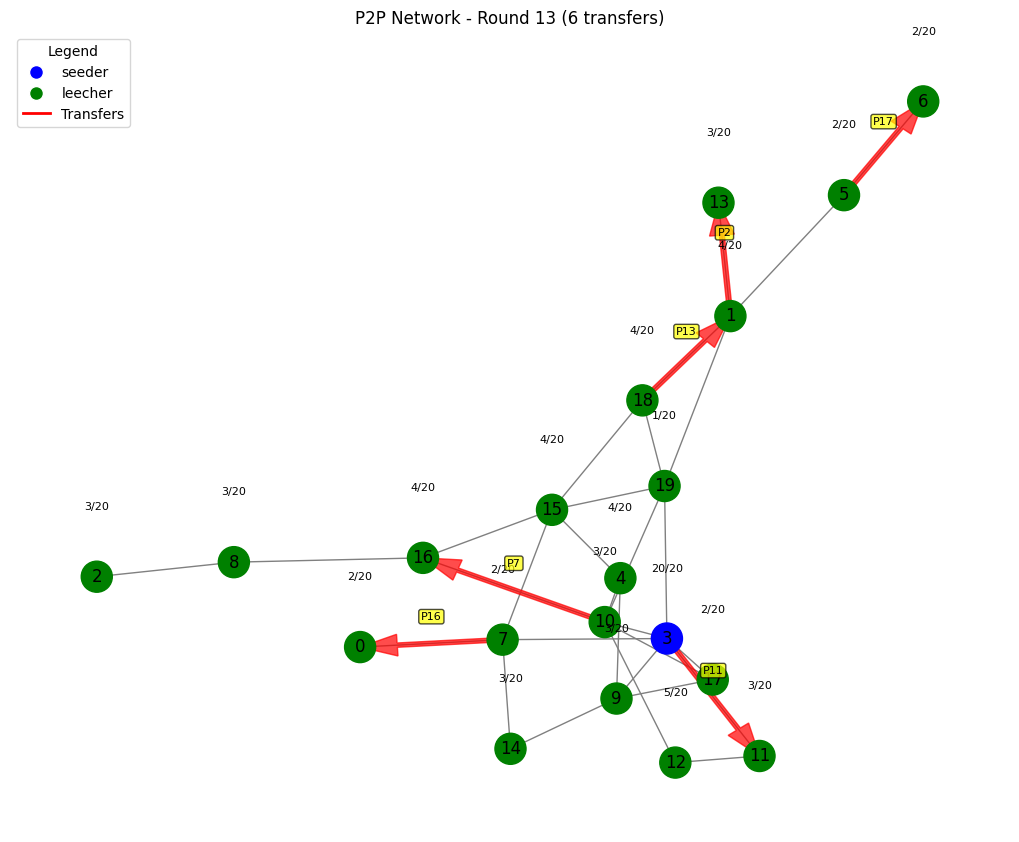


 Round 14
Transfers: 6
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 13: 1 to >> 13
  Piece 14: 3 to >> 10
  Piece 7: 10 to >> 4
  Piece 11: 11 to >> 12
  Piece 17: 15 to >> 16
  Piece 7: 16 to >> 15


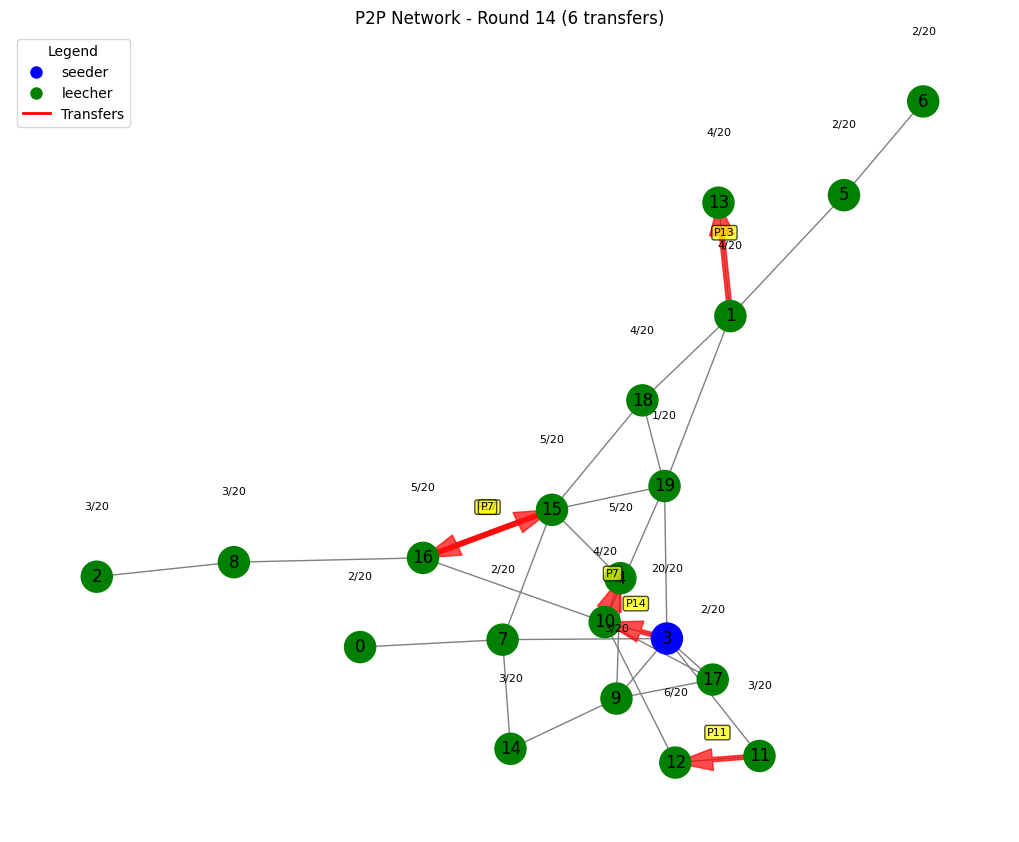


 Round 15
Transfers: 5
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 13: 1 to >> 5
  Piece 3: 3 to >> 9
  Piece 14: 10 to >> 12
  Piece 7: 15 to >> 18
  Piece 17: 16 to >> 8


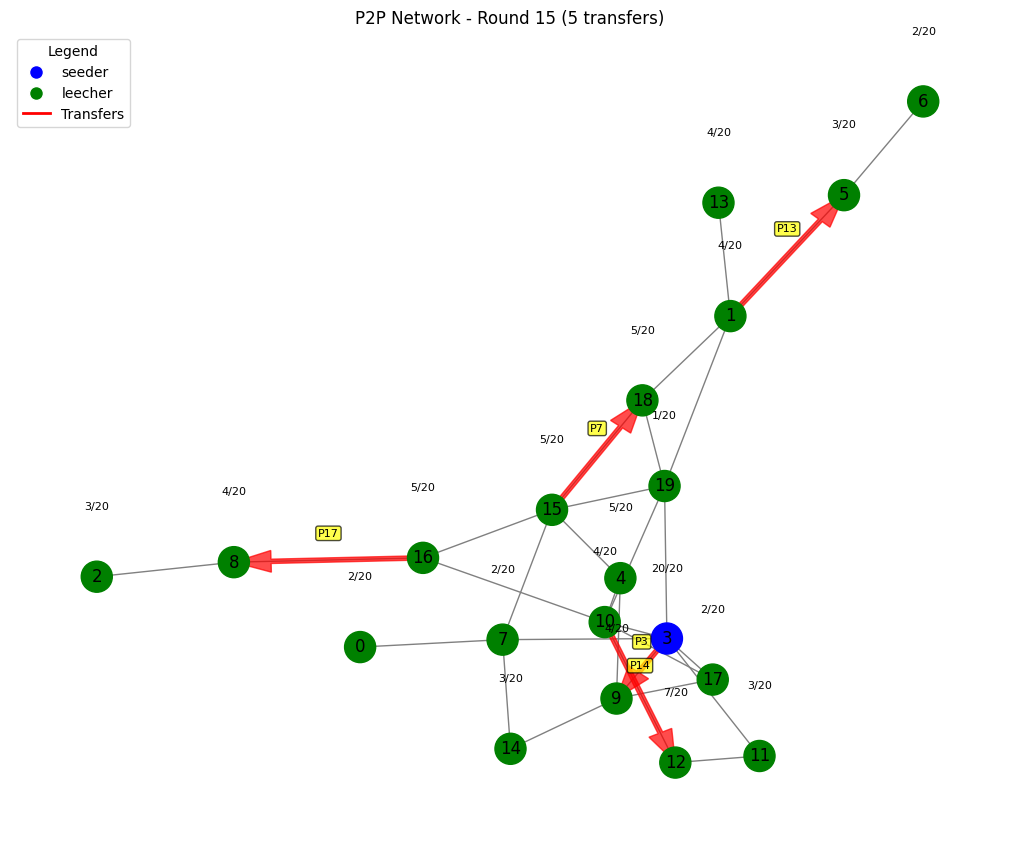


 Round 16
Transfers: 8
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 13: 1 to >> 19
  Piece 13: 3 to >> 7
  Piece 13: 5 to >> 6
  Piece 17: 8 to >> 2
  Piece 3: 9 to >> 14
  Piece 14: 10 to >> 16
  Piece 7: 16 to >> 8
  Piece 7: 18 to >> 1


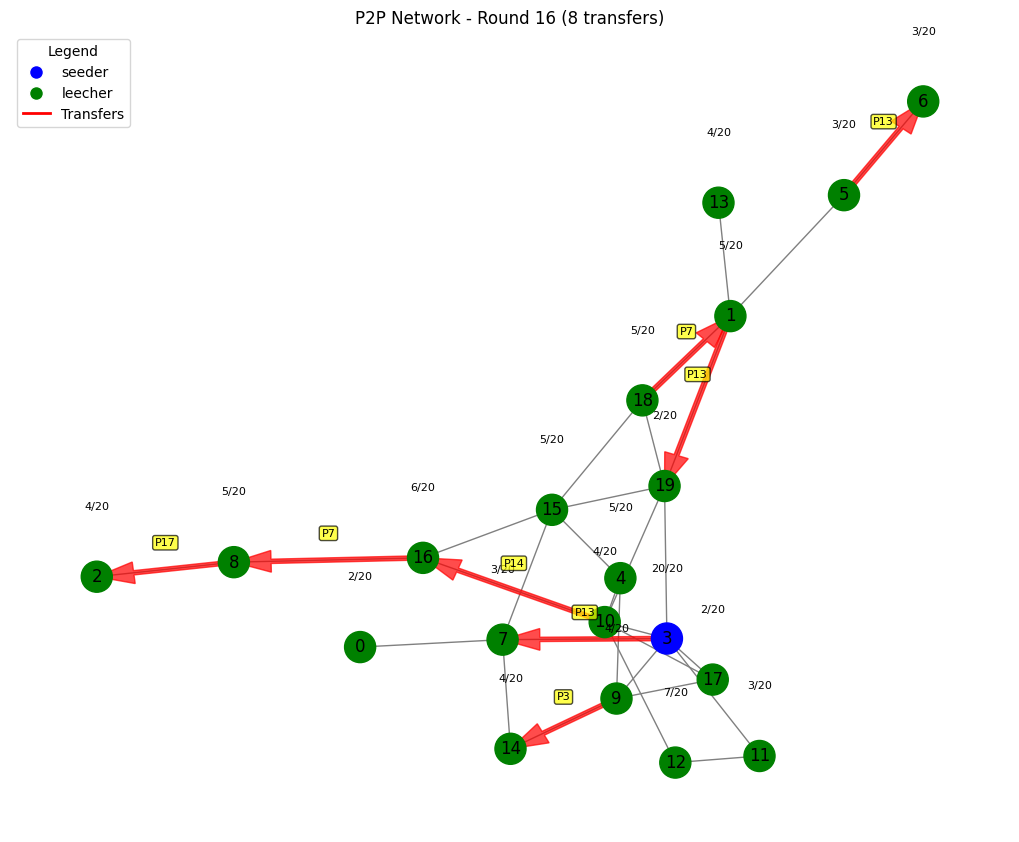


 Round 17
Transfers: 6
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 17: 1 to >> 19
  Piece 12: 3 to >> 9
  Piece 13: 7 to >> 0
  Piece 7: 8 to >> 2
  Piece 3: 9 to >> 4
  Piece 14: 16 to >> 15


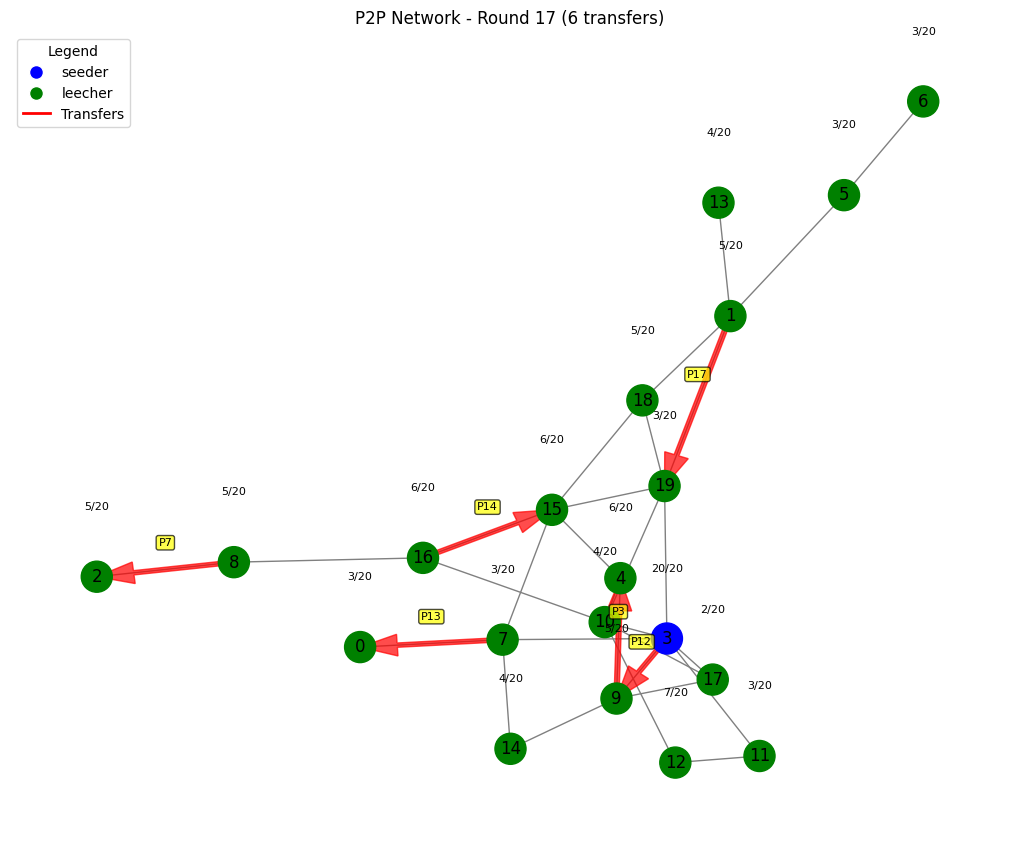


 Round 18
Transfers: 6
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 2: 1 to >> 19
  Piece 1: 3 to >> 9
  Piece 3: 4 to >> 15
  Piece 12: 9 to >> 4
  Piece 14: 15 to >> 18
  Piece 14: 16 to >> 8


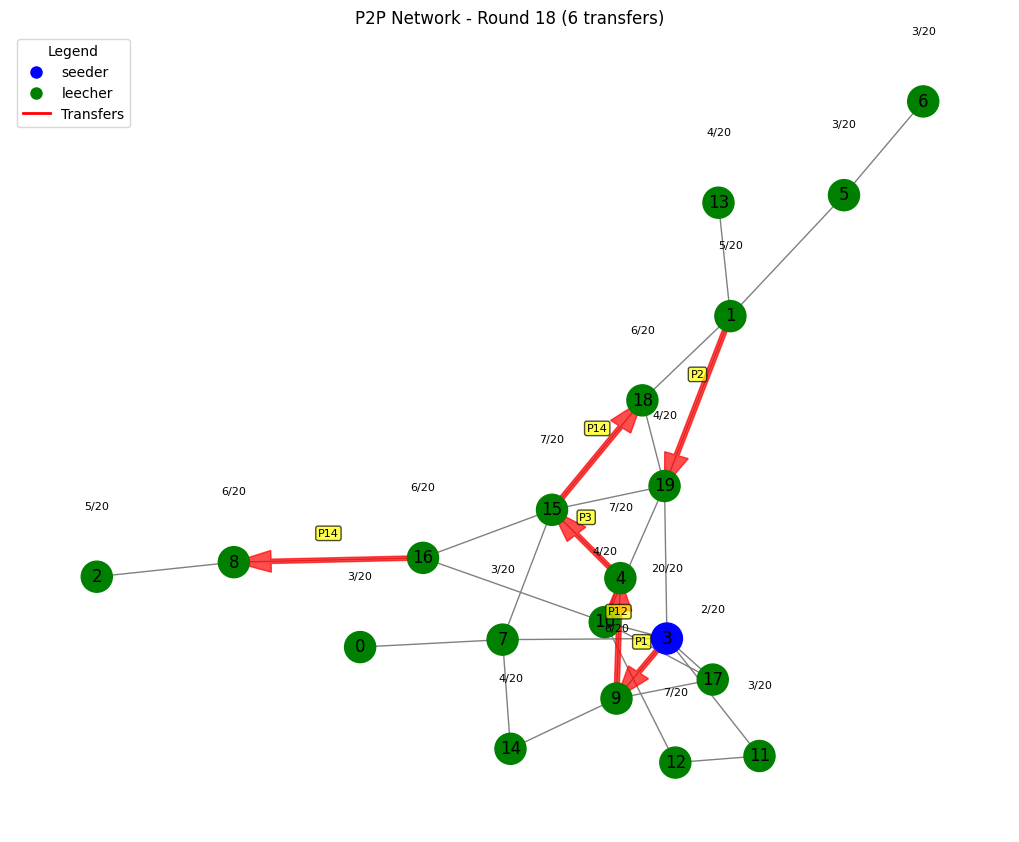


 Round 19
Transfers: 7
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 7: 1 to >> 13
  Piece 4: 3 to >> 17
  Piece 12: 4 to >> 15
  Piece 14: 8 to >> 2
  Piece 12: 9 to >> 14
  Piece 3: 15 to >> 16
  Piece 14: 18 to >> 1


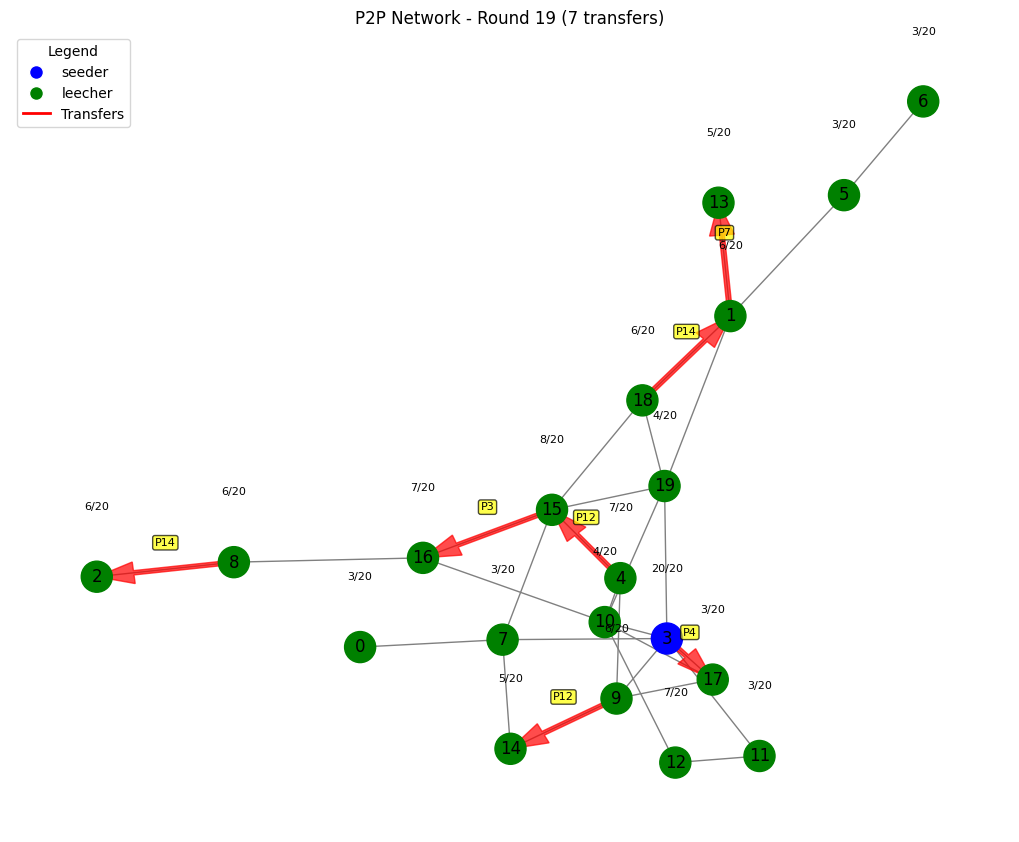


 Round 20
Transfers: 5
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 7: 1 to >> 19
  Piece 1: 3 to >> 11
  Piece 1: 9 to >> 14
  Piece 12: 15 to >> 16
  Piece 3: 16 to >> 8


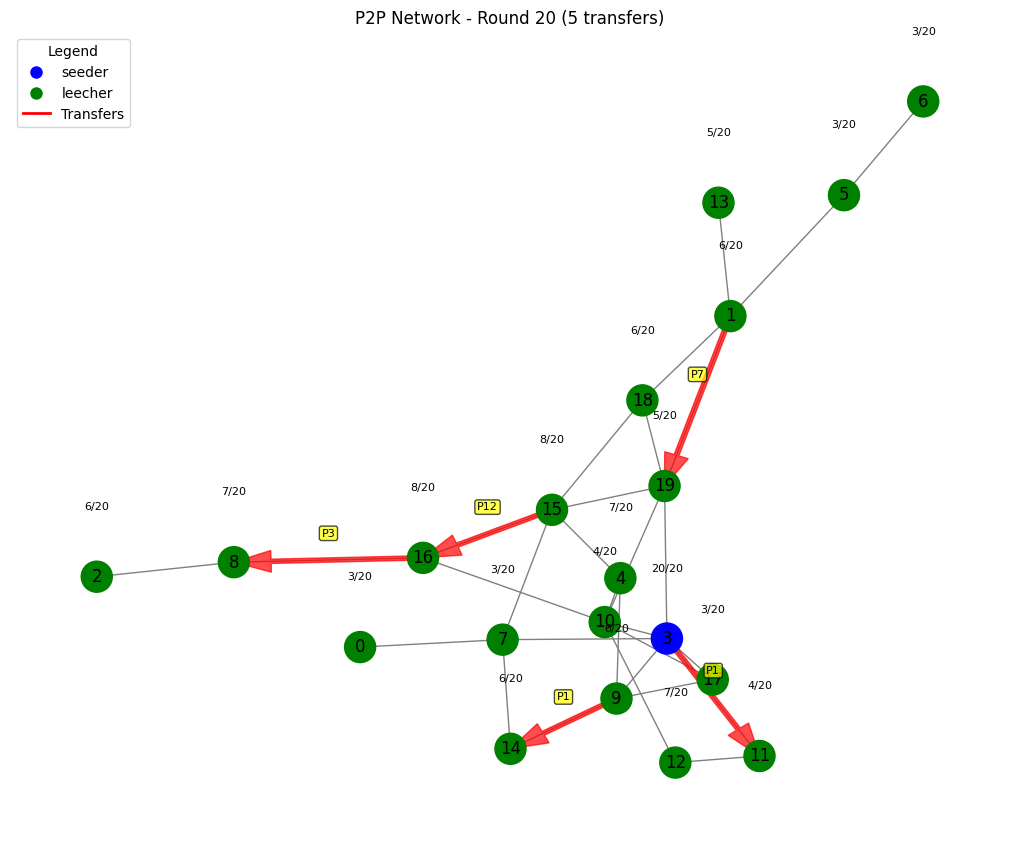


 Round 21
Transfers: 7
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 14: 1 to >> 13
  Piece 5: 3 to >> 10
  Piece 3: 8 to >> 2
  Piece 1: 9 to >> 4
  Piece 1: 11 to >> 12
  Piece 3: 15 to >> 18
  Piece 12: 16 to >> 8


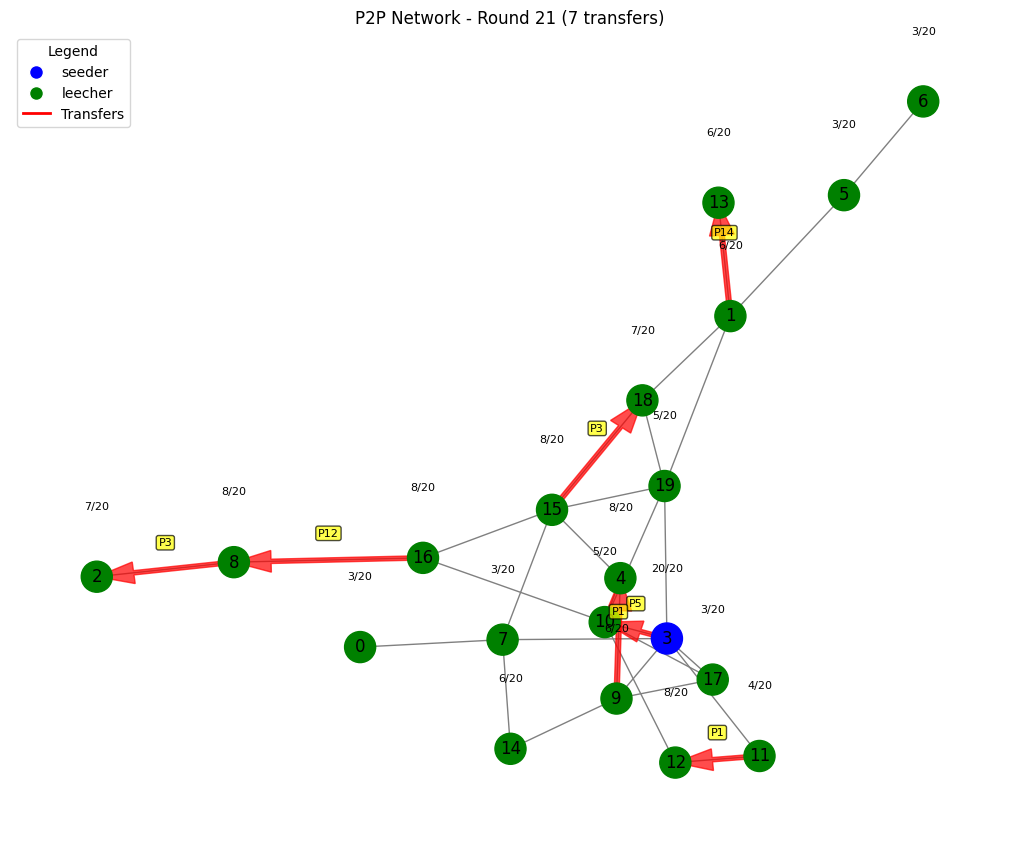


 Round 22
Transfers: 7
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 14: 1 to >> 19
  Piece 7: 3 to >> 9
  Piece 1: 4 to >> 15
  Piece 12: 8 to >> 2
  Piece 5: 10 to >> 12
  Piece 12: 15 to >> 18
  Piece 3: 18 to >> 1


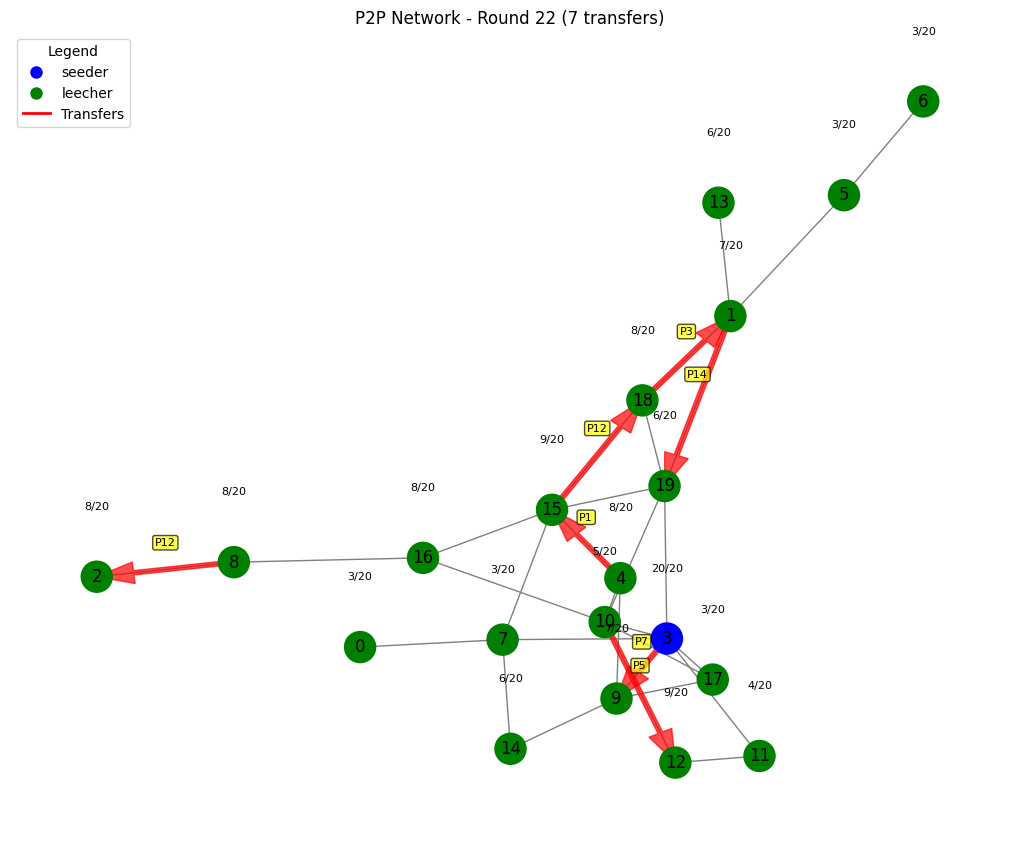


 Round 23
Transfers: 6
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 3: 1 to >> 19
  Piece 12: 3 to >> 11
  Piece 7: 9 to >> 14
  Piece 5: 10 to >> 16
  Piece 1: 15 to >> 18
  Piece 12: 18 to >> 1


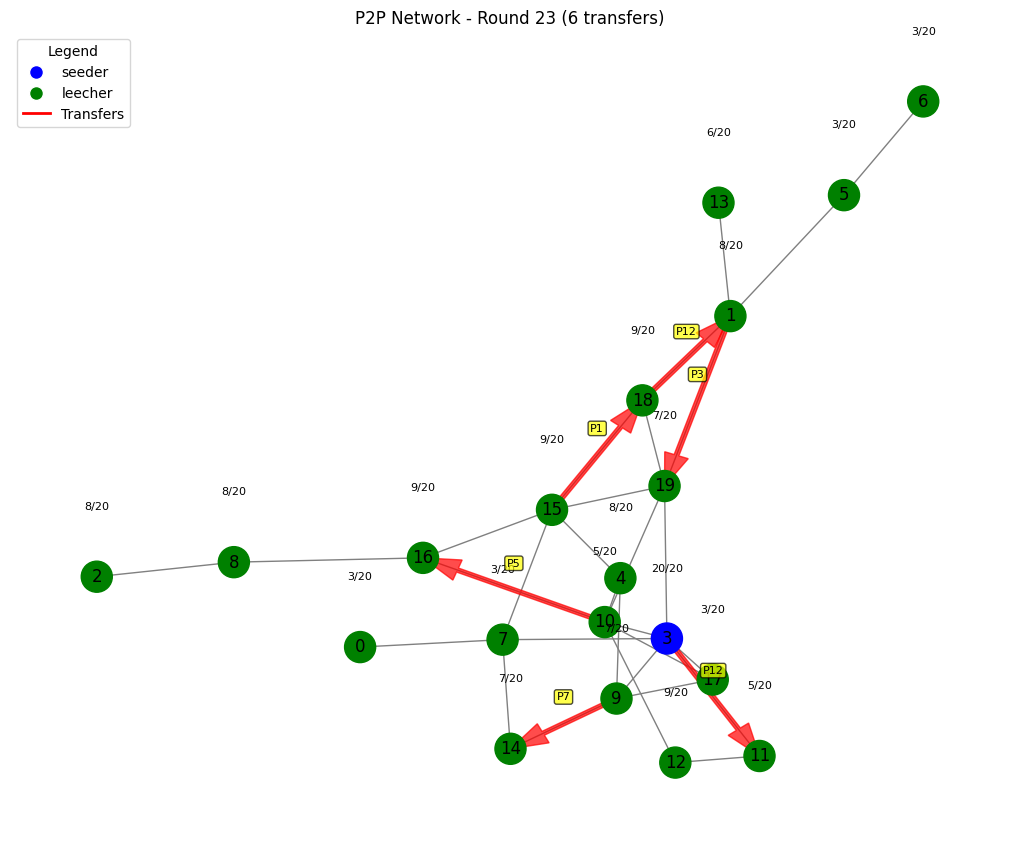


 Round 24
Transfers: 7
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 12: 1 to >> 13
  Piece 12: 3 to >> 10
  Piece 5: 10 to >> 4
  Piece 12: 11 to >> 12
  Piece 1: 15 to >> 16
  Piece 5: 16 to >> 15
  Piece 1: 18 to >> 1


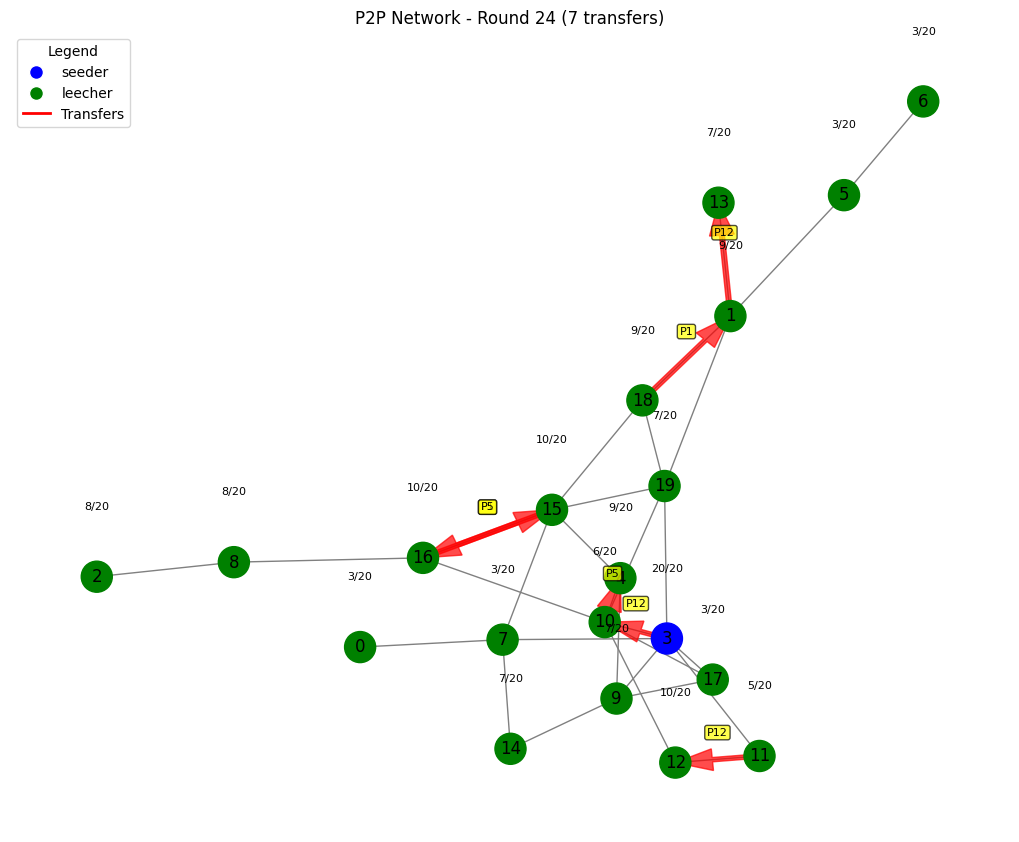


 Round 25
Transfers: 5
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 12: 1 to >> 5
  Piece 5: 3 to >> 17
  Piece 14: 10 to >> 4
  Piece 5: 15 to >> 18
  Piece 5: 16 to >> 8


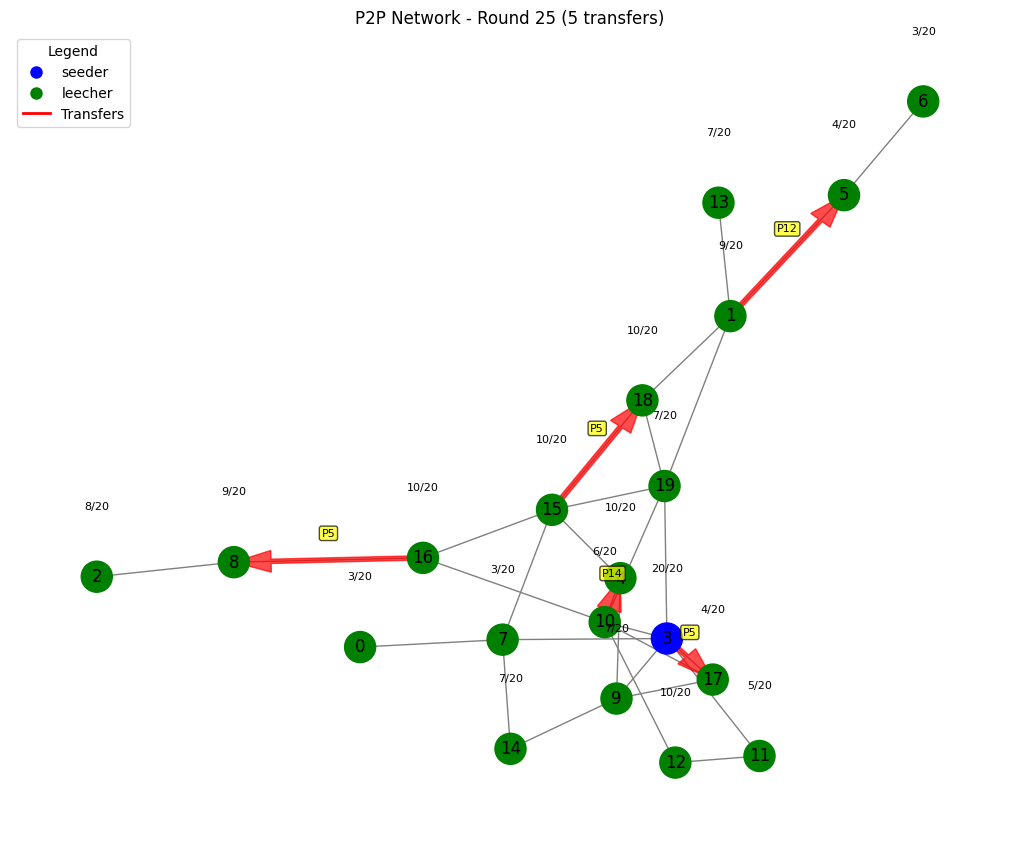


 Round 26
Transfers: 6
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 12: 1 to >> 19
  Piece 9: 3 to >> 11
  Piece 12: 5 to >> 6
  Piece 5: 8 to >> 2
  Piece 1: 16 to >> 8
  Piece 5: 18 to >> 1


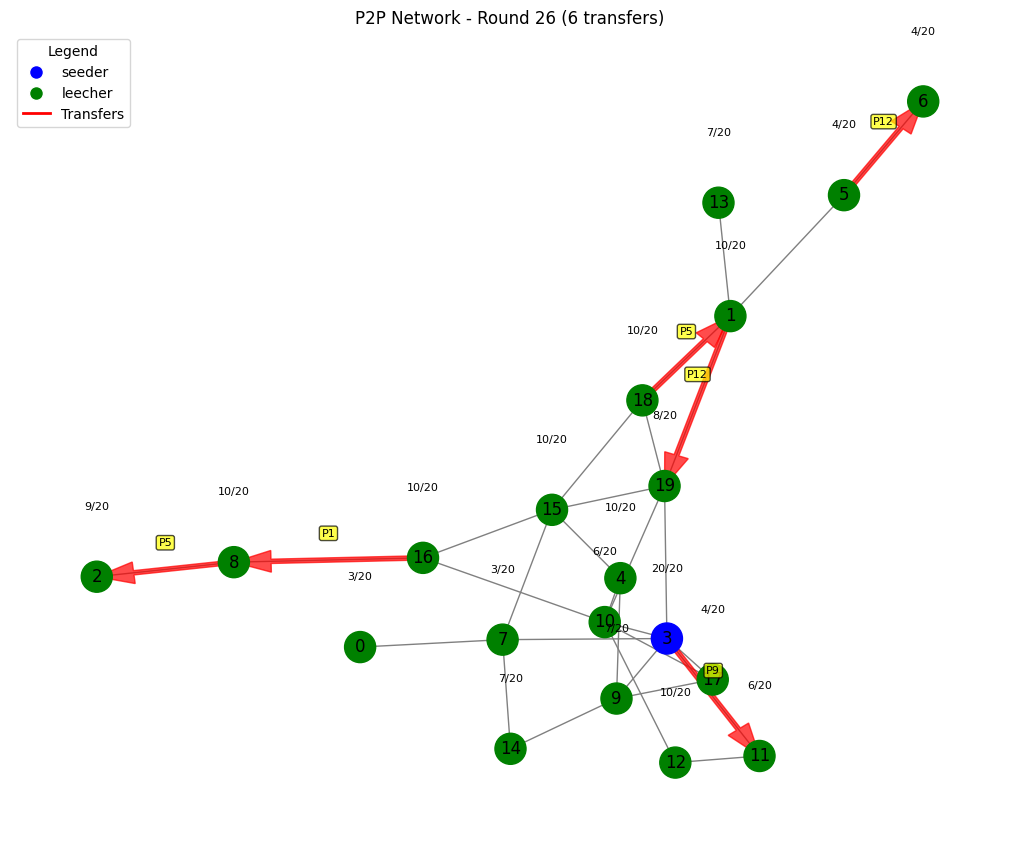


 Round 27
Transfers: 4
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 5: 1 to >> 19
  Piece 15: 3 to >> 9
  Piece 1: 8 to >> 2
  Piece 9: 11 to >> 12


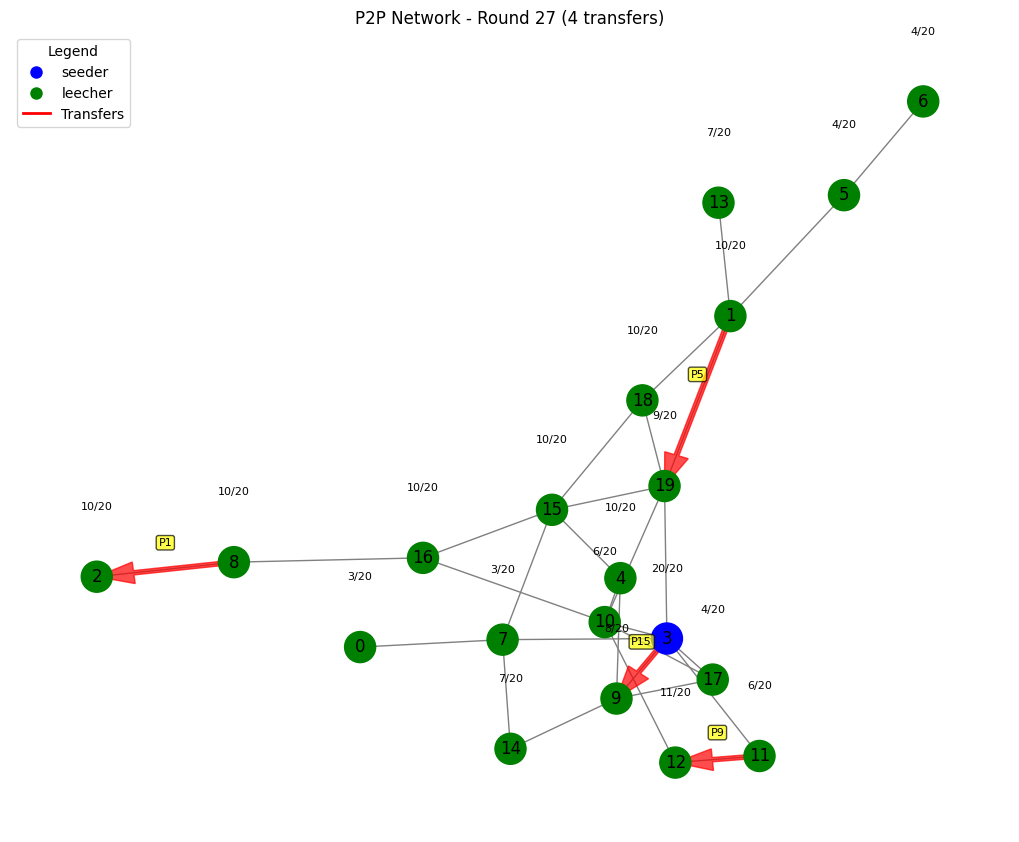


 Round 28
Transfers: 3
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 1: 1 to >> 13
  Piece 8: 3 to >> 17
  Piece 15: 9 to >> 14


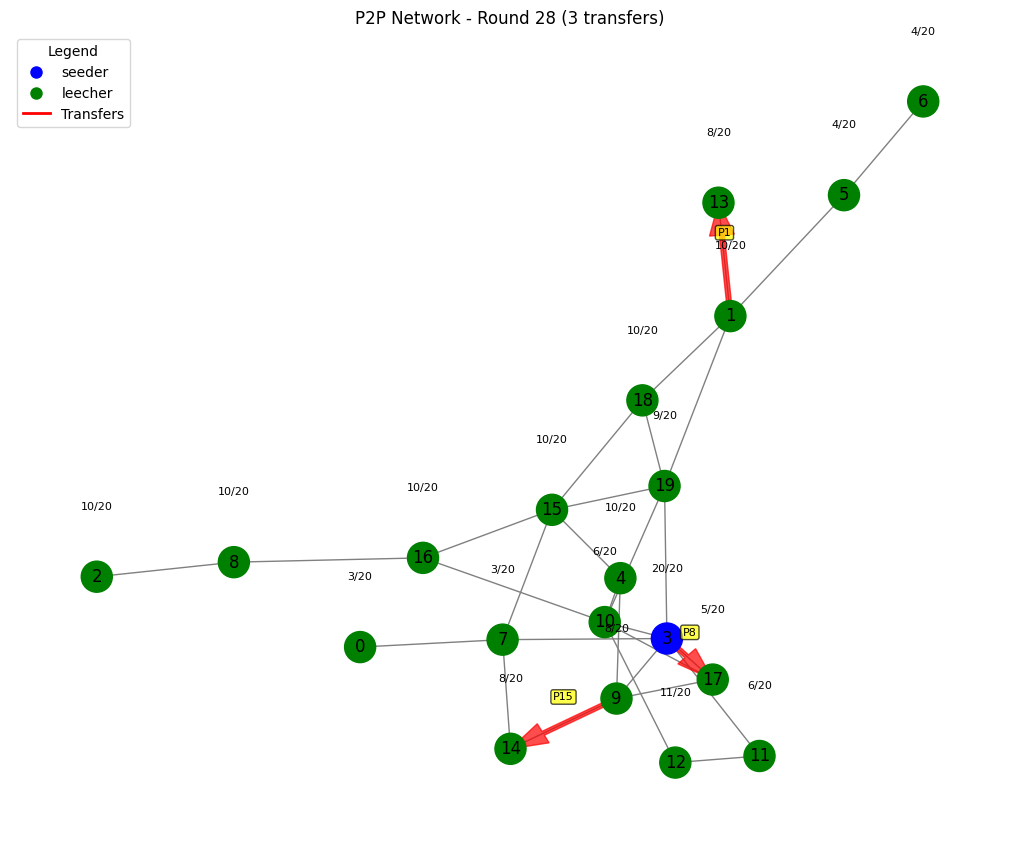


 Round 29
Transfers: 3
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 5: 1 to >> 13
  Piece 14: 3 to >> 9
  Piece 15: 9 to >> 4


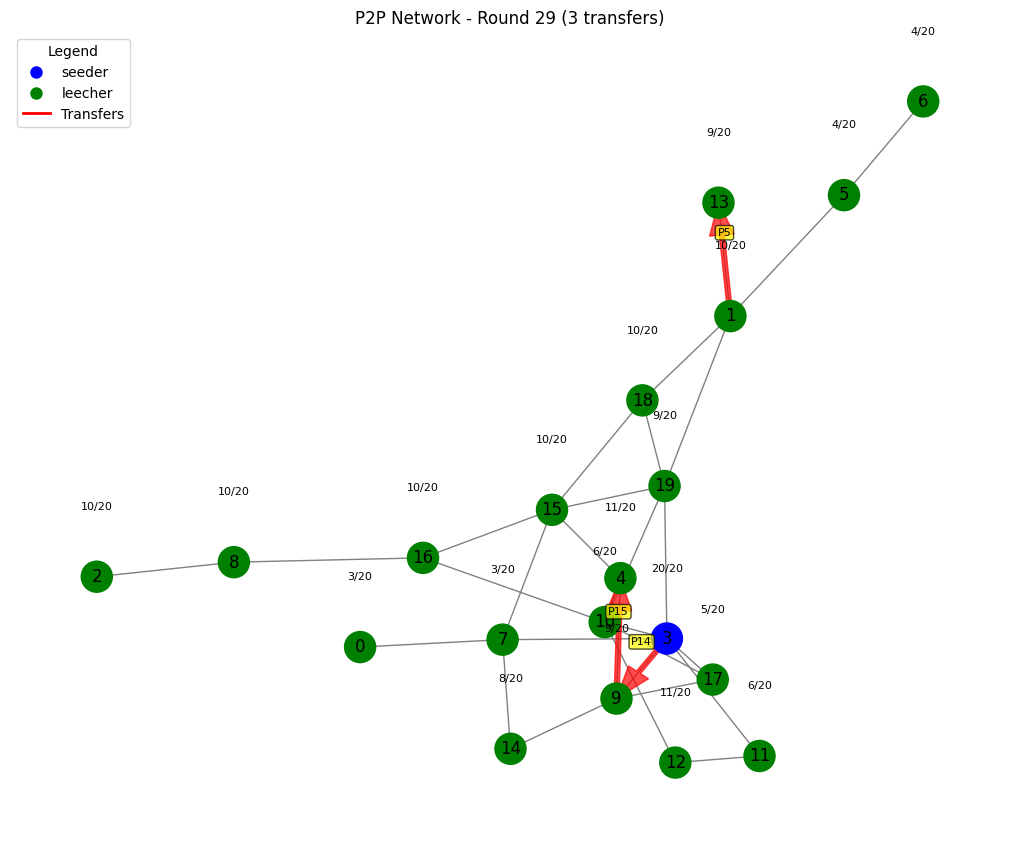


 Round 30
Transfers: 4
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 1: 1 to >> 19
  Piece 18: 3 to >> 17
  Piece 15: 4 to >> 15
  Piece 14: 9 to >> 14


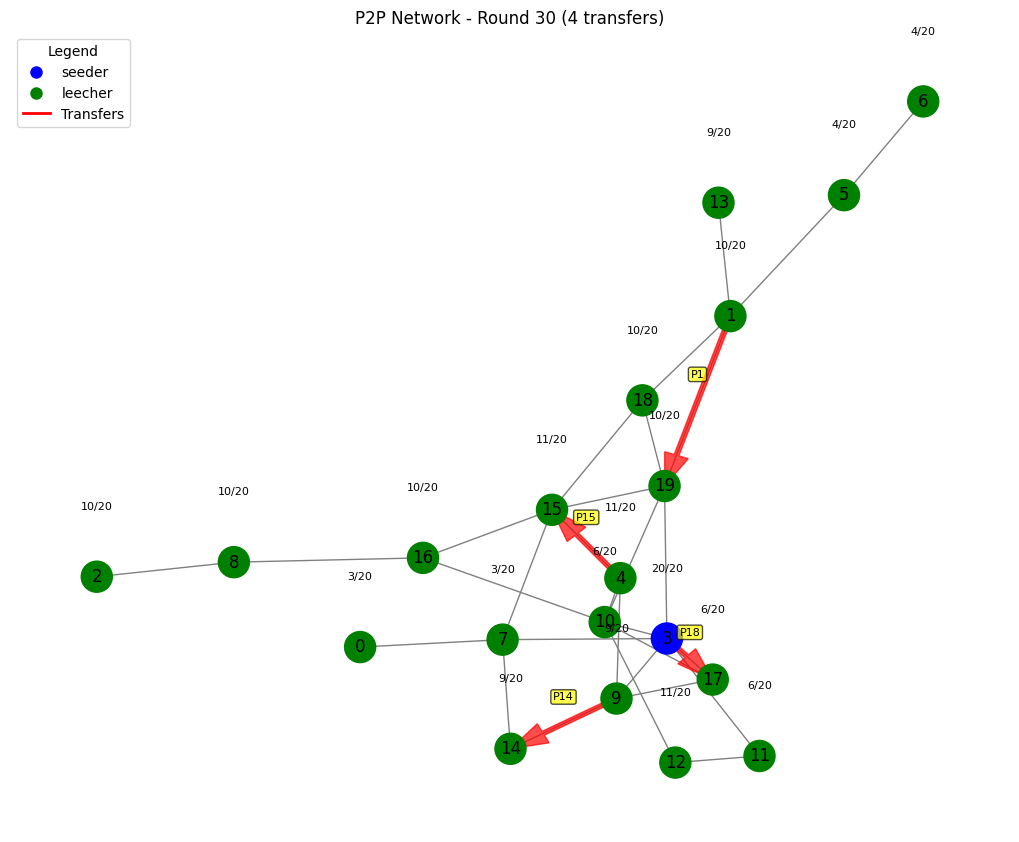


 Round 31
Transfers: 3
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 3: 1 to >> 13
  Piece 10: 3 to >> 7
  Piece 15: 15 to >> 18


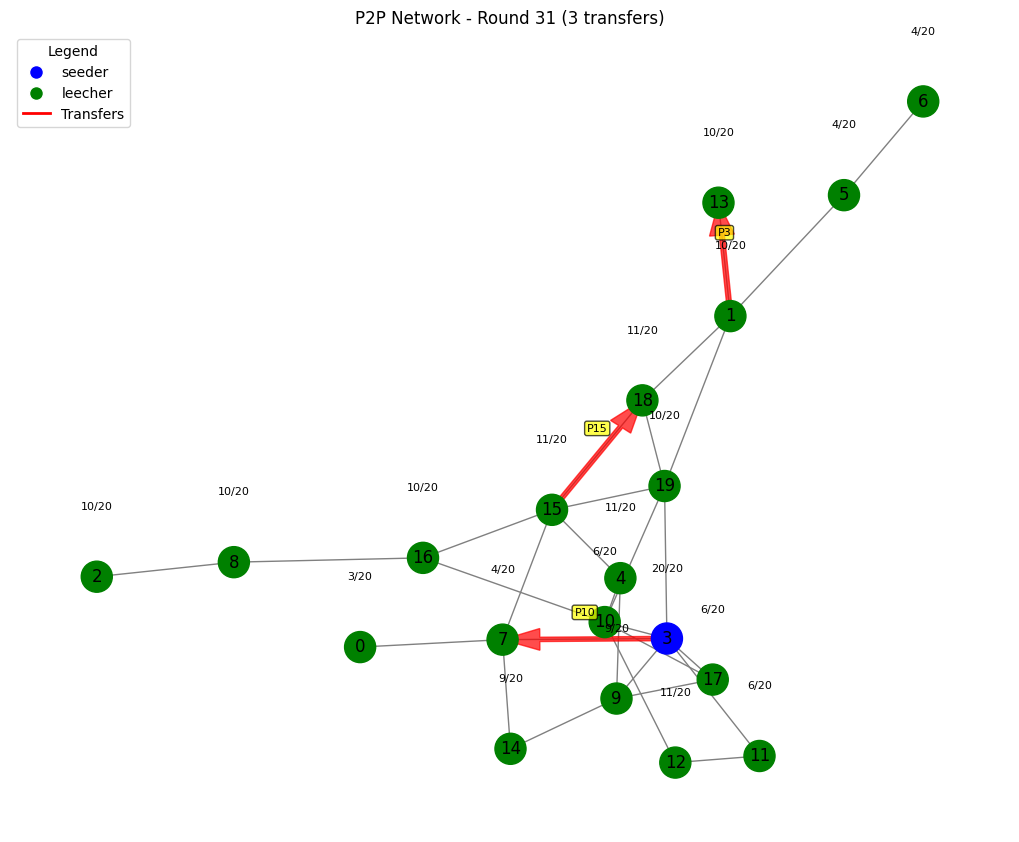


 Round 32
Transfers: 5
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 5: 1 to >> 5
  Piece 10: 3 to >> 10
  Piece 10: 7 to >> 0
  Piece 15: 15 to >> 16
  Piece 15: 18 to >> 1


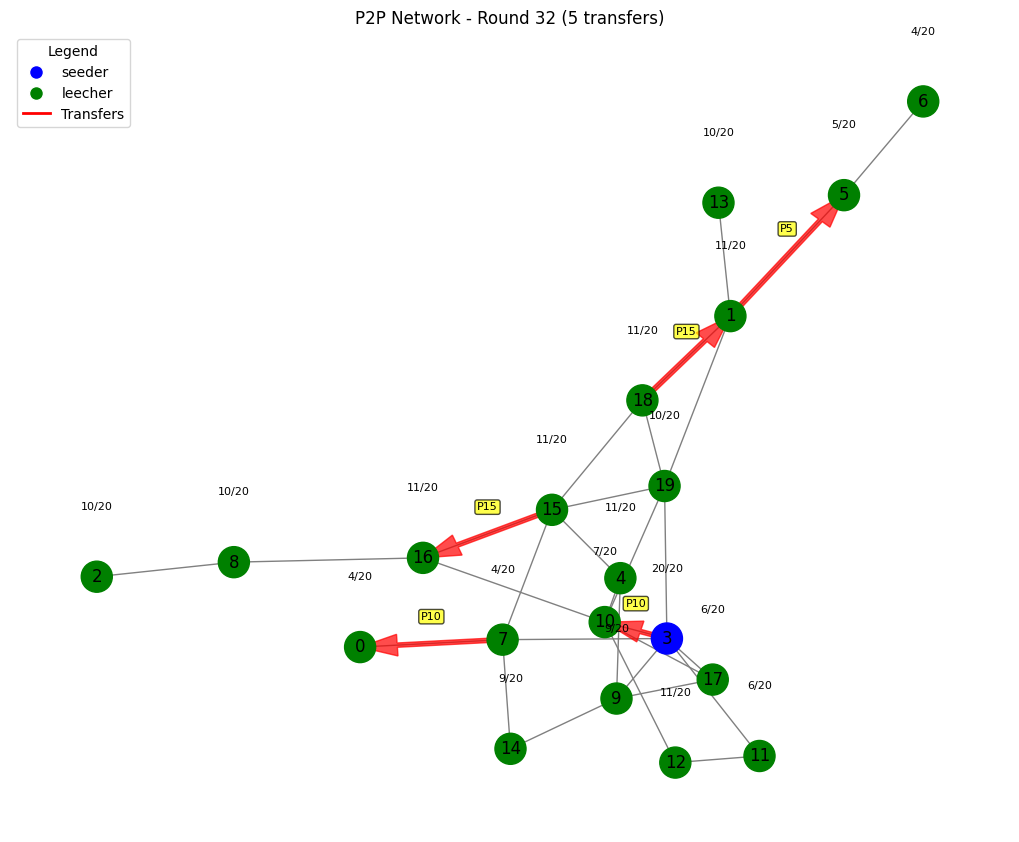


 Round 33
Transfers: 6
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 15: 1 to >> 5
  Piece 3: 3 to >> 11
  Piece 5: 5 to >> 6
  Piece 10: 7 to >> 14
  Piece 10: 10 to >> 4
  Piece 15: 16 to >> 8


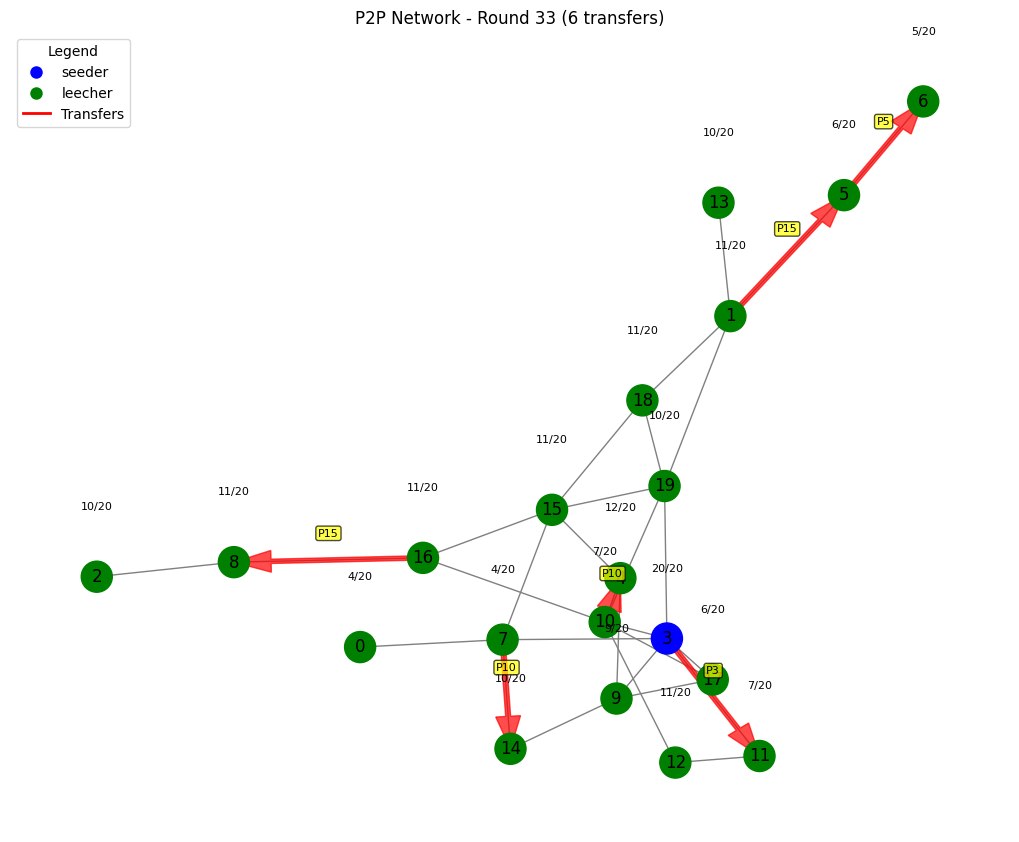


 Round 34
Transfers: 7
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 15: 1 to >> 19
  Piece 11: 3 to >> 9
  Piece 10: 4 to >> 15
  Piece 15: 5 to >> 6
  Piece 15: 8 to >> 2
  Piece 10: 10 to >> 16
  Piece 3: 11 to >> 12


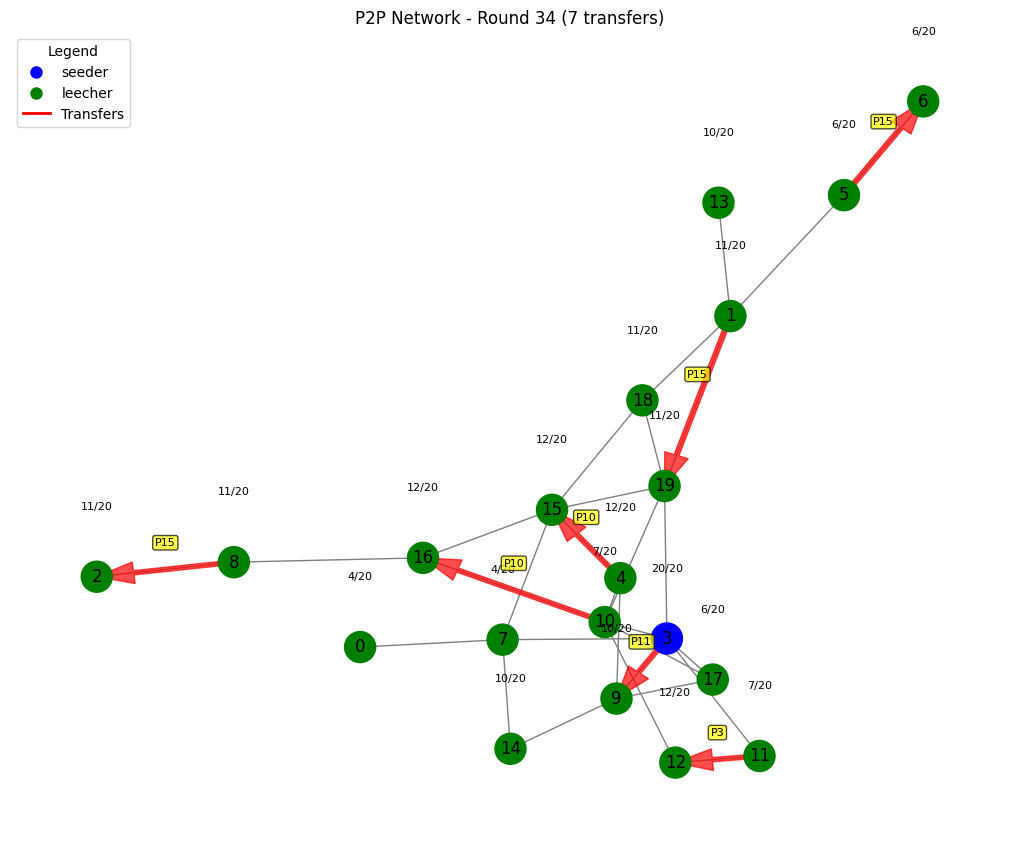


 Round 35
Transfers: 5
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 2: 1 to >> 5
  Piece 6: 3 to >> 19
  Piece 11: 9 to >> 4
  Piece 10: 15 to >> 18
  Piece 10: 16 to >> 8


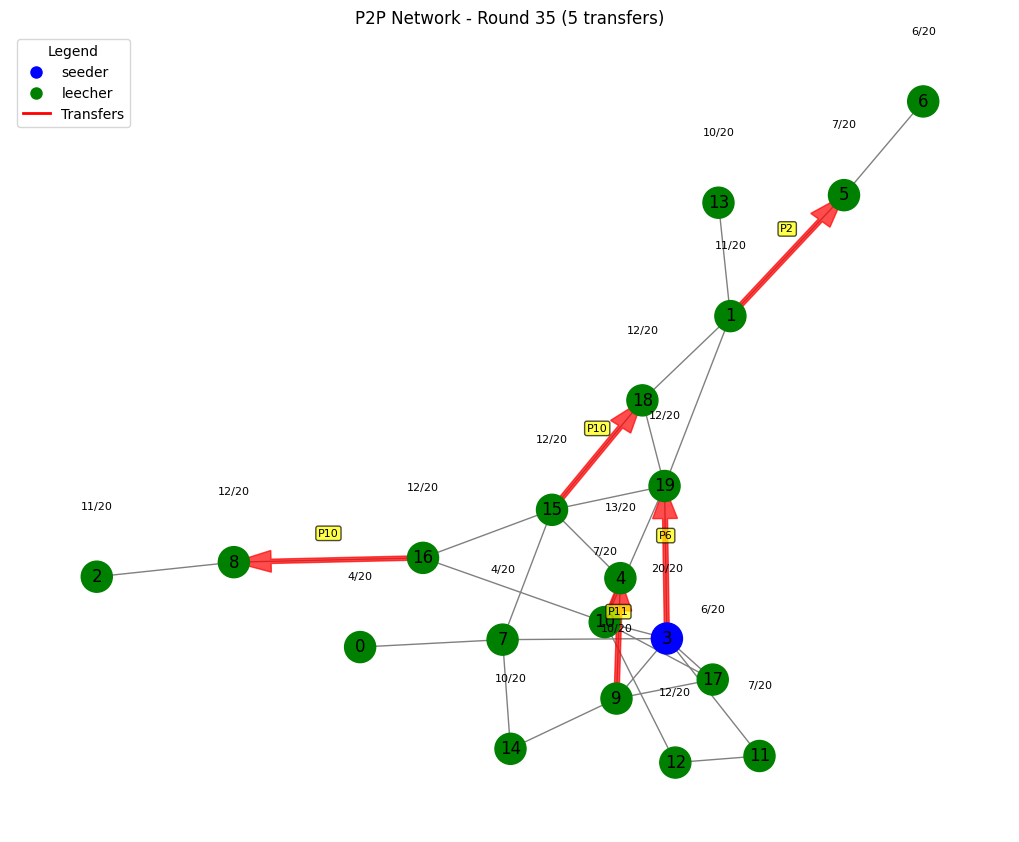


 Round 36
Transfers: 8
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 15: 1 to >> 13
  Piece 0: 3 to >> 9
  Piece 11: 4 to >> 15
  Piece 2: 5 to >> 6
  Piece 10: 8 to >> 2
  Piece 11: 9 to >> 14
  Piece 10: 18 to >> 1
  Piece 6: 19 to >> 18


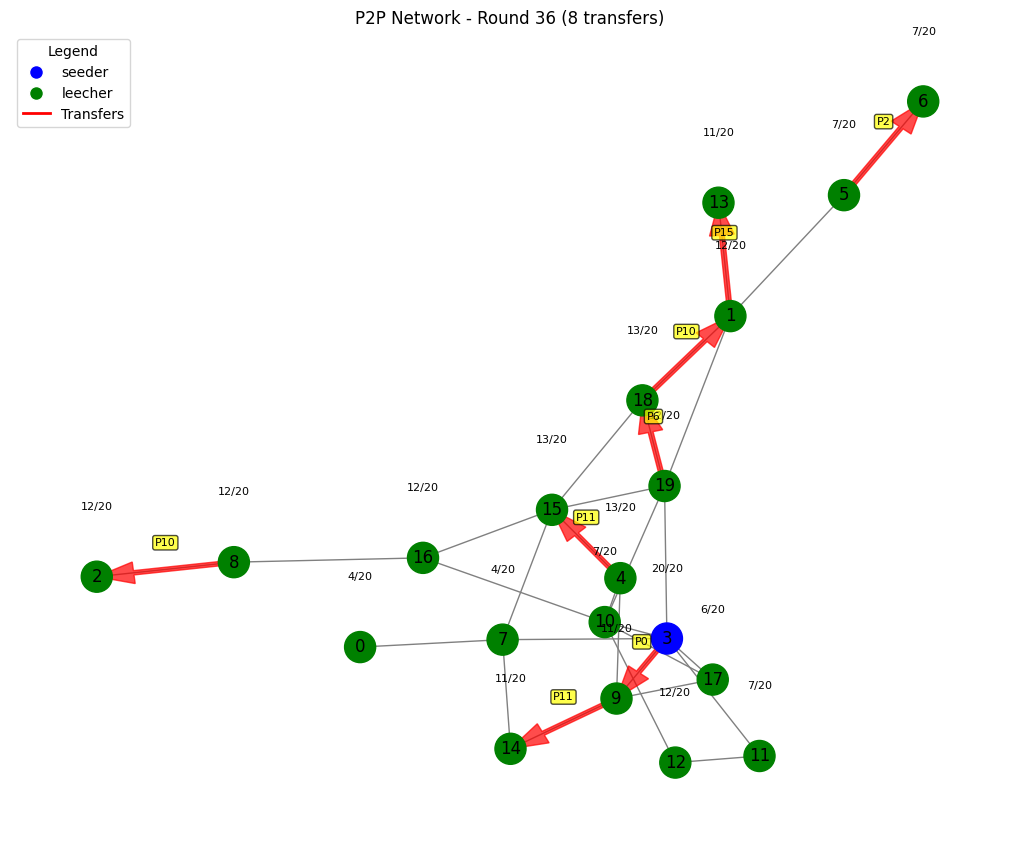


 Round 37
Transfers: 5
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 10: 1 to >> 13
  Piece 15: 3 to >> 17
  Piece 0: 9 to >> 14
  Piece 11: 15 to >> 16
  Piece 6: 18 to >> 1


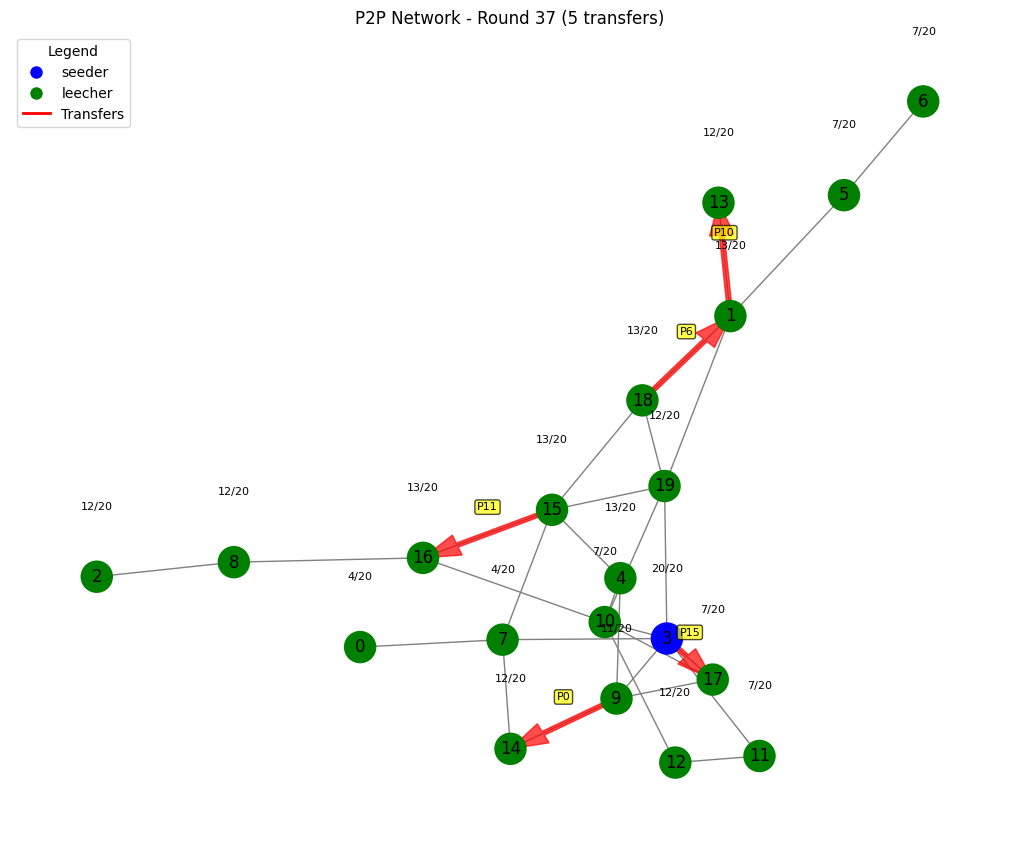


 Round 38
Transfers: 6
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 10: 1 to >> 19
  Piece 16: 3 to >> 11
  Piece 0: 9 to >> 4
  Piece 11: 15 to >> 18
  Piece 11: 16 to >> 8
  Piece 6: 18 to >> 15


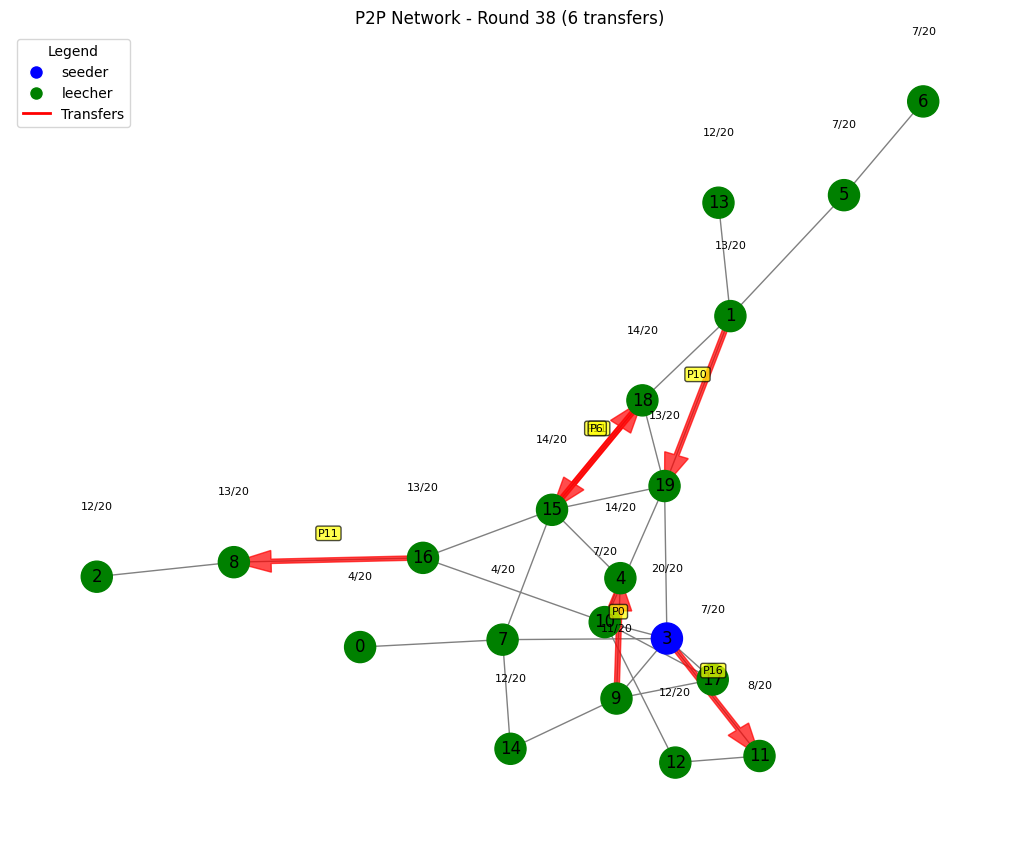


 Round 39
Transfers: 7
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 6: 1 to >> 13
  Piece 19: 3 to >> 19
  Piece 0: 4 to >> 15
  Piece 11: 8 to >> 2
  Piece 16: 11 to >> 12
  Piece 6: 15 to >> 4
  Piece 11: 18 to >> 1


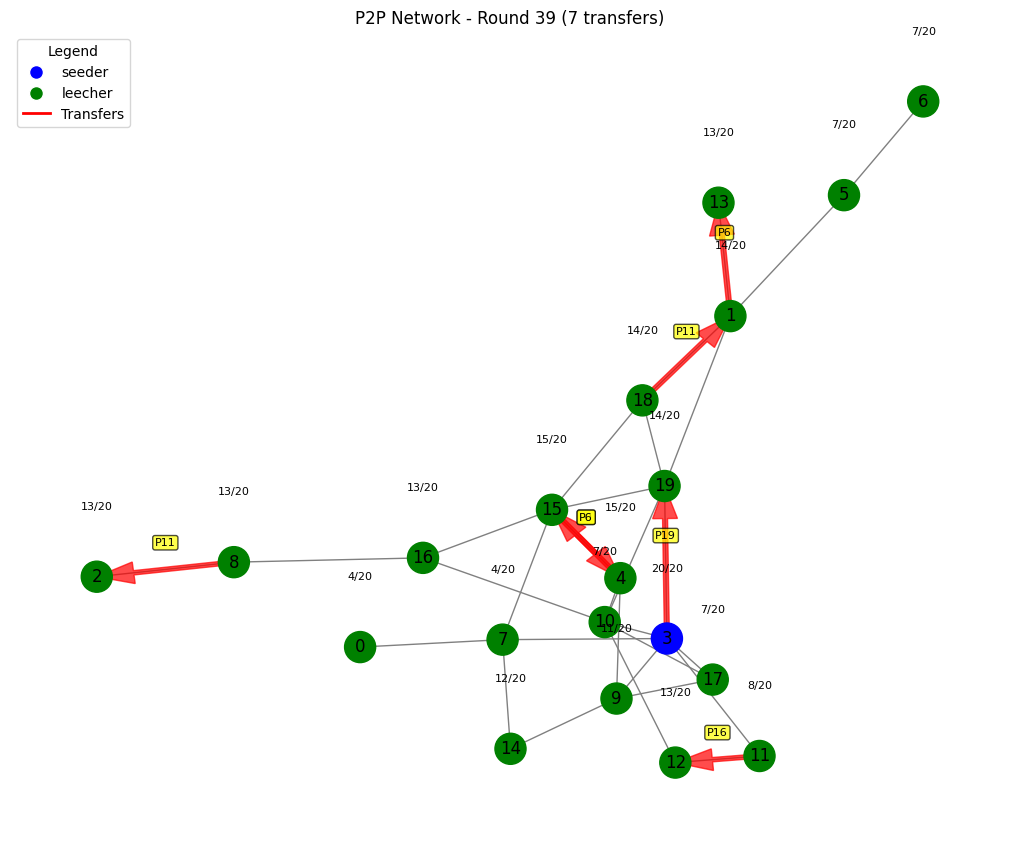


Final network state:
Node 0: leecher - 4/20 pieces - Complete: False
Node 1: leecher - 14/20 pieces - Complete: False
Node 2: leecher - 13/20 pieces - Complete: False
Node 3: seeder - 20/20 pieces - Complete: True
Node 4: leecher - 15/20 pieces - Complete: False
Node 5: leecher - 7/20 pieces - Complete: False
Node 6: leecher - 7/20 pieces - Complete: False
Node 7: leecher - 4/20 pieces - Complete: False
Node 8: leecher - 13/20 pieces - Complete: False
Node 9: leecher - 11/20 pieces - Complete: False
Node 10: leecher - 7/20 pieces - Complete: False
Node 11: leecher - 8/20 pieces - Complete: False
Node 12: leecher - 13/20 pieces - Complete: False
Node 13: leecher - 13/20 pieces - Complete: False
Node 14: leecher - 12/20 pieces - Complete: False
Node 15: leecher - 15/20 pieces - Complete: False
Node 16: leecher - 13/20 pieces - Complete: False
Node 17: leecher - 7/20 pieces - Complete: False
Node 18: leecher - 14/20 pieces - Complete: False
Node 19: leecher - 14/20 pieces - Complete: Fal

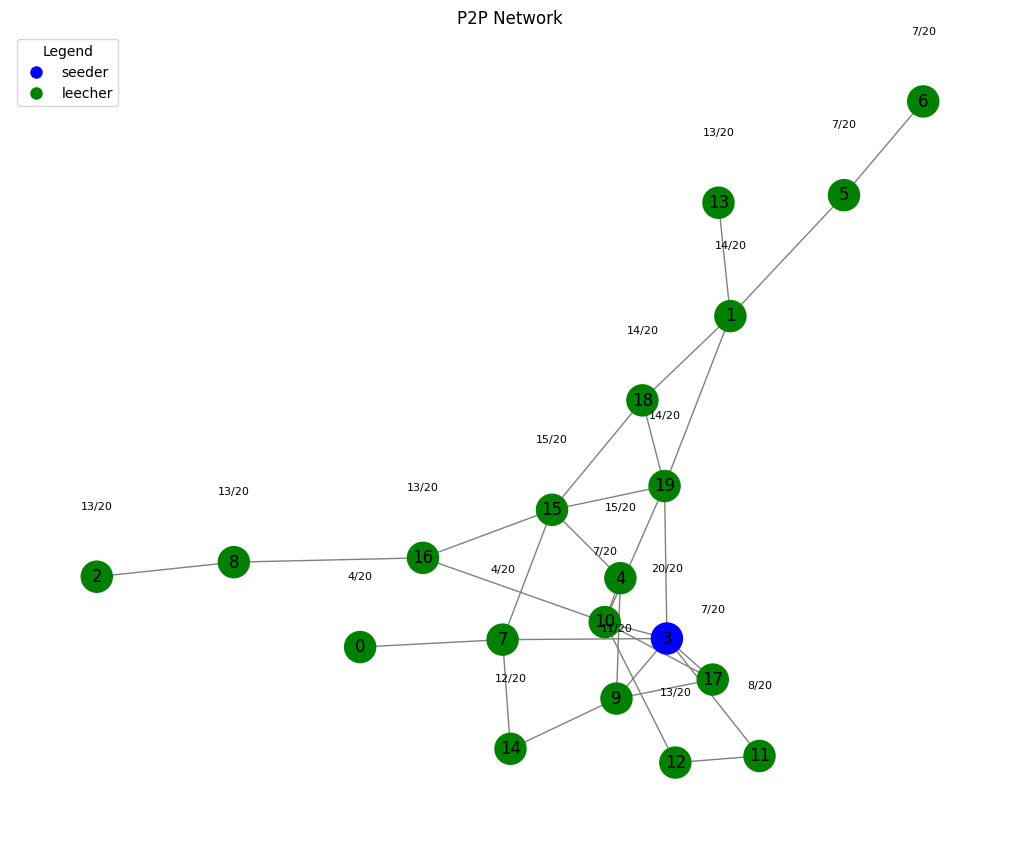

In [5]:
stats = get_network_stats(G, FILE_PIECES)
print(f"Initial: {stats['incomplete_leechers']} leechers incomplete, {stats['completion_rate']:.1%} completion rate")

# Run one round of simulation
for round_num in range(1, 40):
    print(f"\n Round {round_num}")
    result = simulate_round(G, FILE_PIECES, seed=42+round_num)
    
    print(f"Transfers: {result['total_transfers']}")
    if result['new_completions']:
        print(f"New completions: {result['new_completions']}")
    
    stats = get_network_stats(G, FILE_PIECES)
    print(f"Progress: {stats['incomplete_leechers']} leechers incomplete, {stats['completion_rate']:.1%} completion rate")
    
    # Show some transfer details
    if result['transfers']:
        print("transfers:")
        for transfer in result['transfers']:  # Show first handful
            print(f"  Piece {transfer['piece']}: {transfer['from']} to >> {transfer['to']}")
    draw_graph_with_transfers(G, FILE_PIECES, result['transfers'], round_num)
print(f"\nFinal network state:")
for node in G.nodes():
    info = agent_module.get_agent_info(G, node)
    print(f"Node {node}: {info['role']} - {info['num_pieces']}/20 pieces - Complete: {info['is_complete']}")

final_stats = get_network_stats(G, FILE_PIECES)

print(f"\nFinal network statistics:")
print(f"Total nodes: {final_stats['total_nodes']}")
print(f"Total edges: {final_stats['total_edges']}")
print(f"Seeders: {final_stats['seeders']}")
print(f"Leechers: {final_stats['leechers']}")
print(f"Complete leechers: {final_stats['complete_leechers']}")
print(f"Incomplete leechers: {final_stats['incomplete_leechers']}")
print(f"Completion rate: {final_stats['completion_rate']:.1%}")
print(f"Total pieces in network: {final_stats['total_pieces_in_network']}")

# Draw the final graph
print(f"\nFinal graph visualization:")
draw_graph(G, FILE_PIECES)